# Illustration of a sample data from Argoverse 2 Motion Forecasting Dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   observed track_id object_type  object_category  timestep  position_x  \
0      True    34861     vehicle                0         0 -324.467841   
1      True    34861     vehicle                0         1 -324.469266   
2      True    34861     vehicle                0         2 -324.471939   
3      True    34861     vehicle                0         3 -324.474907   
4      True    34861     vehicle                0         4 -324.478024   

    position_y   heading    velocity_x    velocity_y  \
0 -1153.480477  2.860113 -2.360225e-16 -2.589164e-18   
1 -1153.477966  2.860182 -2.750969e-16 -5.923612e-17   
2 -1153.474094  2.860252 -3.336415e-16 -3.864316e-17   
3 -1153.469879  2.860321 -3.559718e-16 -2.743535e-18   
4 -1153.464355  2.860572 -3.814046e-16  3.039250e-18   

                            scenario_id  start_timestamp  end_timestamp  \
0  0b3b4

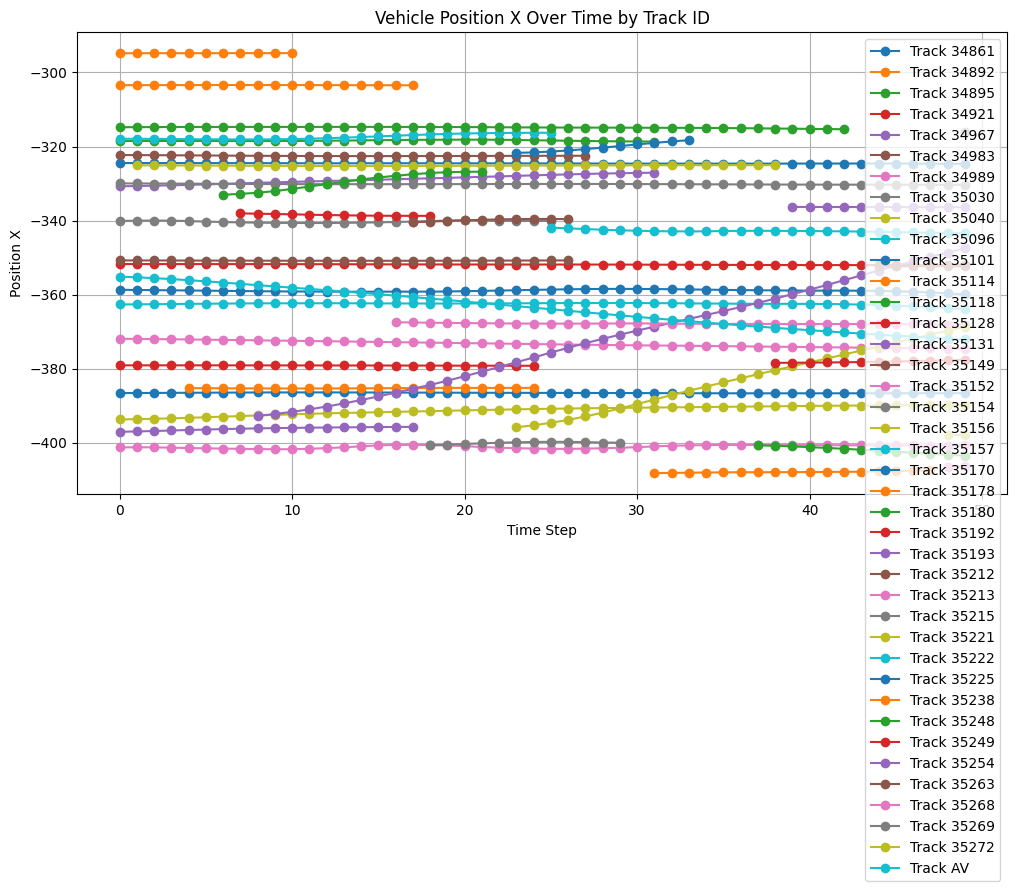

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

parquet_file = '/content/drive/MyDrive/ME343/Final_Project/test/0b3b4036-d003-4caf-a387-1bf069f0810d/scenario_0b3b4036-d003-4caf-a387-1bf069f0810d.parquet'
df = pd.read_parquet(parquet_file)
print(df.head())
print(df.columns)

unique_tracks = df['track_id'].unique()

plt.figure(figsize=(12, 6))

# Plot position_x over time for each track_id
for track_id in unique_tracks:
    track_data = df[df['track_id'] == track_id]
    plt.plot(track_data['timestep'], track_data['position_x'], marker='o', linestyle='-', label=f'Track {track_id}')

plt.xlabel('Time Step')
plt.ylabel('Position X')
plt.title('Vehicle Position X Over Time by Track ID')
plt.legend()
plt.grid(True)
plt.show()

It should be noticed in this task, we will focus on the motion of vehicle with a focal_track_id, which is 34989 in this example. focal_track_id is The track ID associated with the focal agent of the scenario.

# Import the data

In [ ]:
import os
import pandas as pd

base_dir = '/content/drive/MyDrive/ME343/Final_Project/test/'
focal_tracks_data = []

# Iterate through each directory in the base directory
for scenario_dir in os.listdir(base_dir):
    scenario_path = os.path.join(base_dir, scenario_dir)
    if os.path.isdir(scenario_path):
        parquet_file_path = os.path.join(scenario_path, f'scenario_{scenario_dir}.parquet')
        if os.path.exists(parquet_file_path):
            df = pd.read_parquet(parquet_file_path)

            # Extract data for the focal track ID
            if 'focal_track_id' in df.columns and 'track_id' in df.columns:
                focal_track_id = df['focal_track_id'].iloc[0]
                focal_track_data = df[df['track_id'] == focal_track_id]
                focal_tracks_data.append(focal_track_data)
all_focal_tracks_df = pd.concat(focal_tracks_data)
save_csv_path = '/content/drive/MyDrive/ME343/Final_Project/all_focal_tracks.csv'

all_focal_tracks_df.to_csv(save_csv_path, index=False)

# Construction of Dataset for LSTM

In the code below processes trajectory including position, velocity, heading from a dataset grouped by track ID, normalizes these features and labels using MinMax scaling, creates fixed-length sequences, which is 5. Finally, all data are converted into separate tensor for training, validation and testing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# Function to create sequences for LSTM
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        seq = features[i:(i + seq_length)]
        label = labels[i + seq_length]
        sequences.append(seq)
        seq_labels.append(label)
    return np.array(sequences), np.array(seq_labels)

segmented_data = []
scaler = MinMaxScaler()

# Group by 'track_id' to separate different trajectories
for _, group in all_focal_tracks_df.groupby('track_id'):
    group_features = group[['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y']].values
    group_labels = group[['position_x', 'position_y']].values

    # Normalize features within each group
    normalized_features = scaler.fit_transform(group_features)
    labels_scaler = MinMaxScaler()
    normalized_labels = labels_scaler.fit_transform(group_labels)
    seq_length = 5
    X, Y = create_sequences(normalized_features, normalized_labels, seq_length)

    segmented_data.append((X, Y))

X_all = np.concatenate([data[0] for data in segmented_data])
Y_all = np.concatenate([data[1] for data in segmented_data])
total_samples = len(X_all)
train_end_idx = int(total_samples * 0.8)
val_end_idx = train_end_idx + int(total_samples * 0.1)

X_train = X_all[:train_end_idx]
Y_train = Y_all[:train_end_idx]

X_val = X_all[train_end_idx:val_end_idx]
Y_val = Y_all[train_end_idx:val_end_idx]

X_test = X_all[val_end_idx:]
Y_test = Y_all[val_end_idx:]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float).to(device)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float).to(device)


batch_size = 32
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

In [ ]:
!pip install wandb

# Model of simple LSTM

The SimpleLSTM class defines a simple LSTM network structure, comprising a single LSTM layer followed by a linear layer. The LSTM layer takes sequences of a specified input size and processes them using a hidden state of a defined size.

The output of the LSTM is passed through a linear layer to produce the final predictions of the vehicle position of the next time step

In [ ]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        hidden_cell = (torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device),
                       torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device))

        lstm_out, _ = self.lstm(input_seq, hidden_cell)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions


In [ ]:
# Import libraries
import pprint
import numpy as np
import wandb
wandb.login(key="7e90cac615bb30d0f6ff46867fc78524840e4dd4")
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib

wandb: Currently logged in as: zhiyuanl (zhiyuanl925). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Training and plotting

Create sweep with ID: 0gnw08y5
Sweep URL: https://wandb.ai/zhiyuanl925/ME343_FinalProject_TrajectoryPredictions_ZhiyuanLi/sweeps/0gnw08y5


wandb: Agent Starting Run: zkkmppp9 with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Current Epoch: 15/150
The training loss is 0.0013353365939110518
The validation loss is 0.001124282949604094
The mean relative error (in percentage) for the validation set: 0.007656624540686607
Current Epoch: 30/150
The training loss is 0.00025675323558971286
The validation loss is 0.0001582837285241112
The mean relative error (in percentage) for the validation set: 0.002872881479561329
Current Epoch: 45/150
The training loss is 5.425124254543334e-05
The validation loss is 9.852176299318671e-05
The mean relative error (in percentage) for the validation set: 0.002266551833599806
Current Epoch: 60/150
The training loss is 3.863553865812719e-05
The validation loss is 7.526861736550927e-05
The mean relative error (in percentage) for the validation set: 0.0019811003003269434
Current Epoch: 75/150
The training loss is 2.931419476226438e-05
The validation loss is 6.911534001119435e-05
The mean relative error (in percentage) for the validation set: 0.0018983958289027214
Current Epoch: 90/150
T

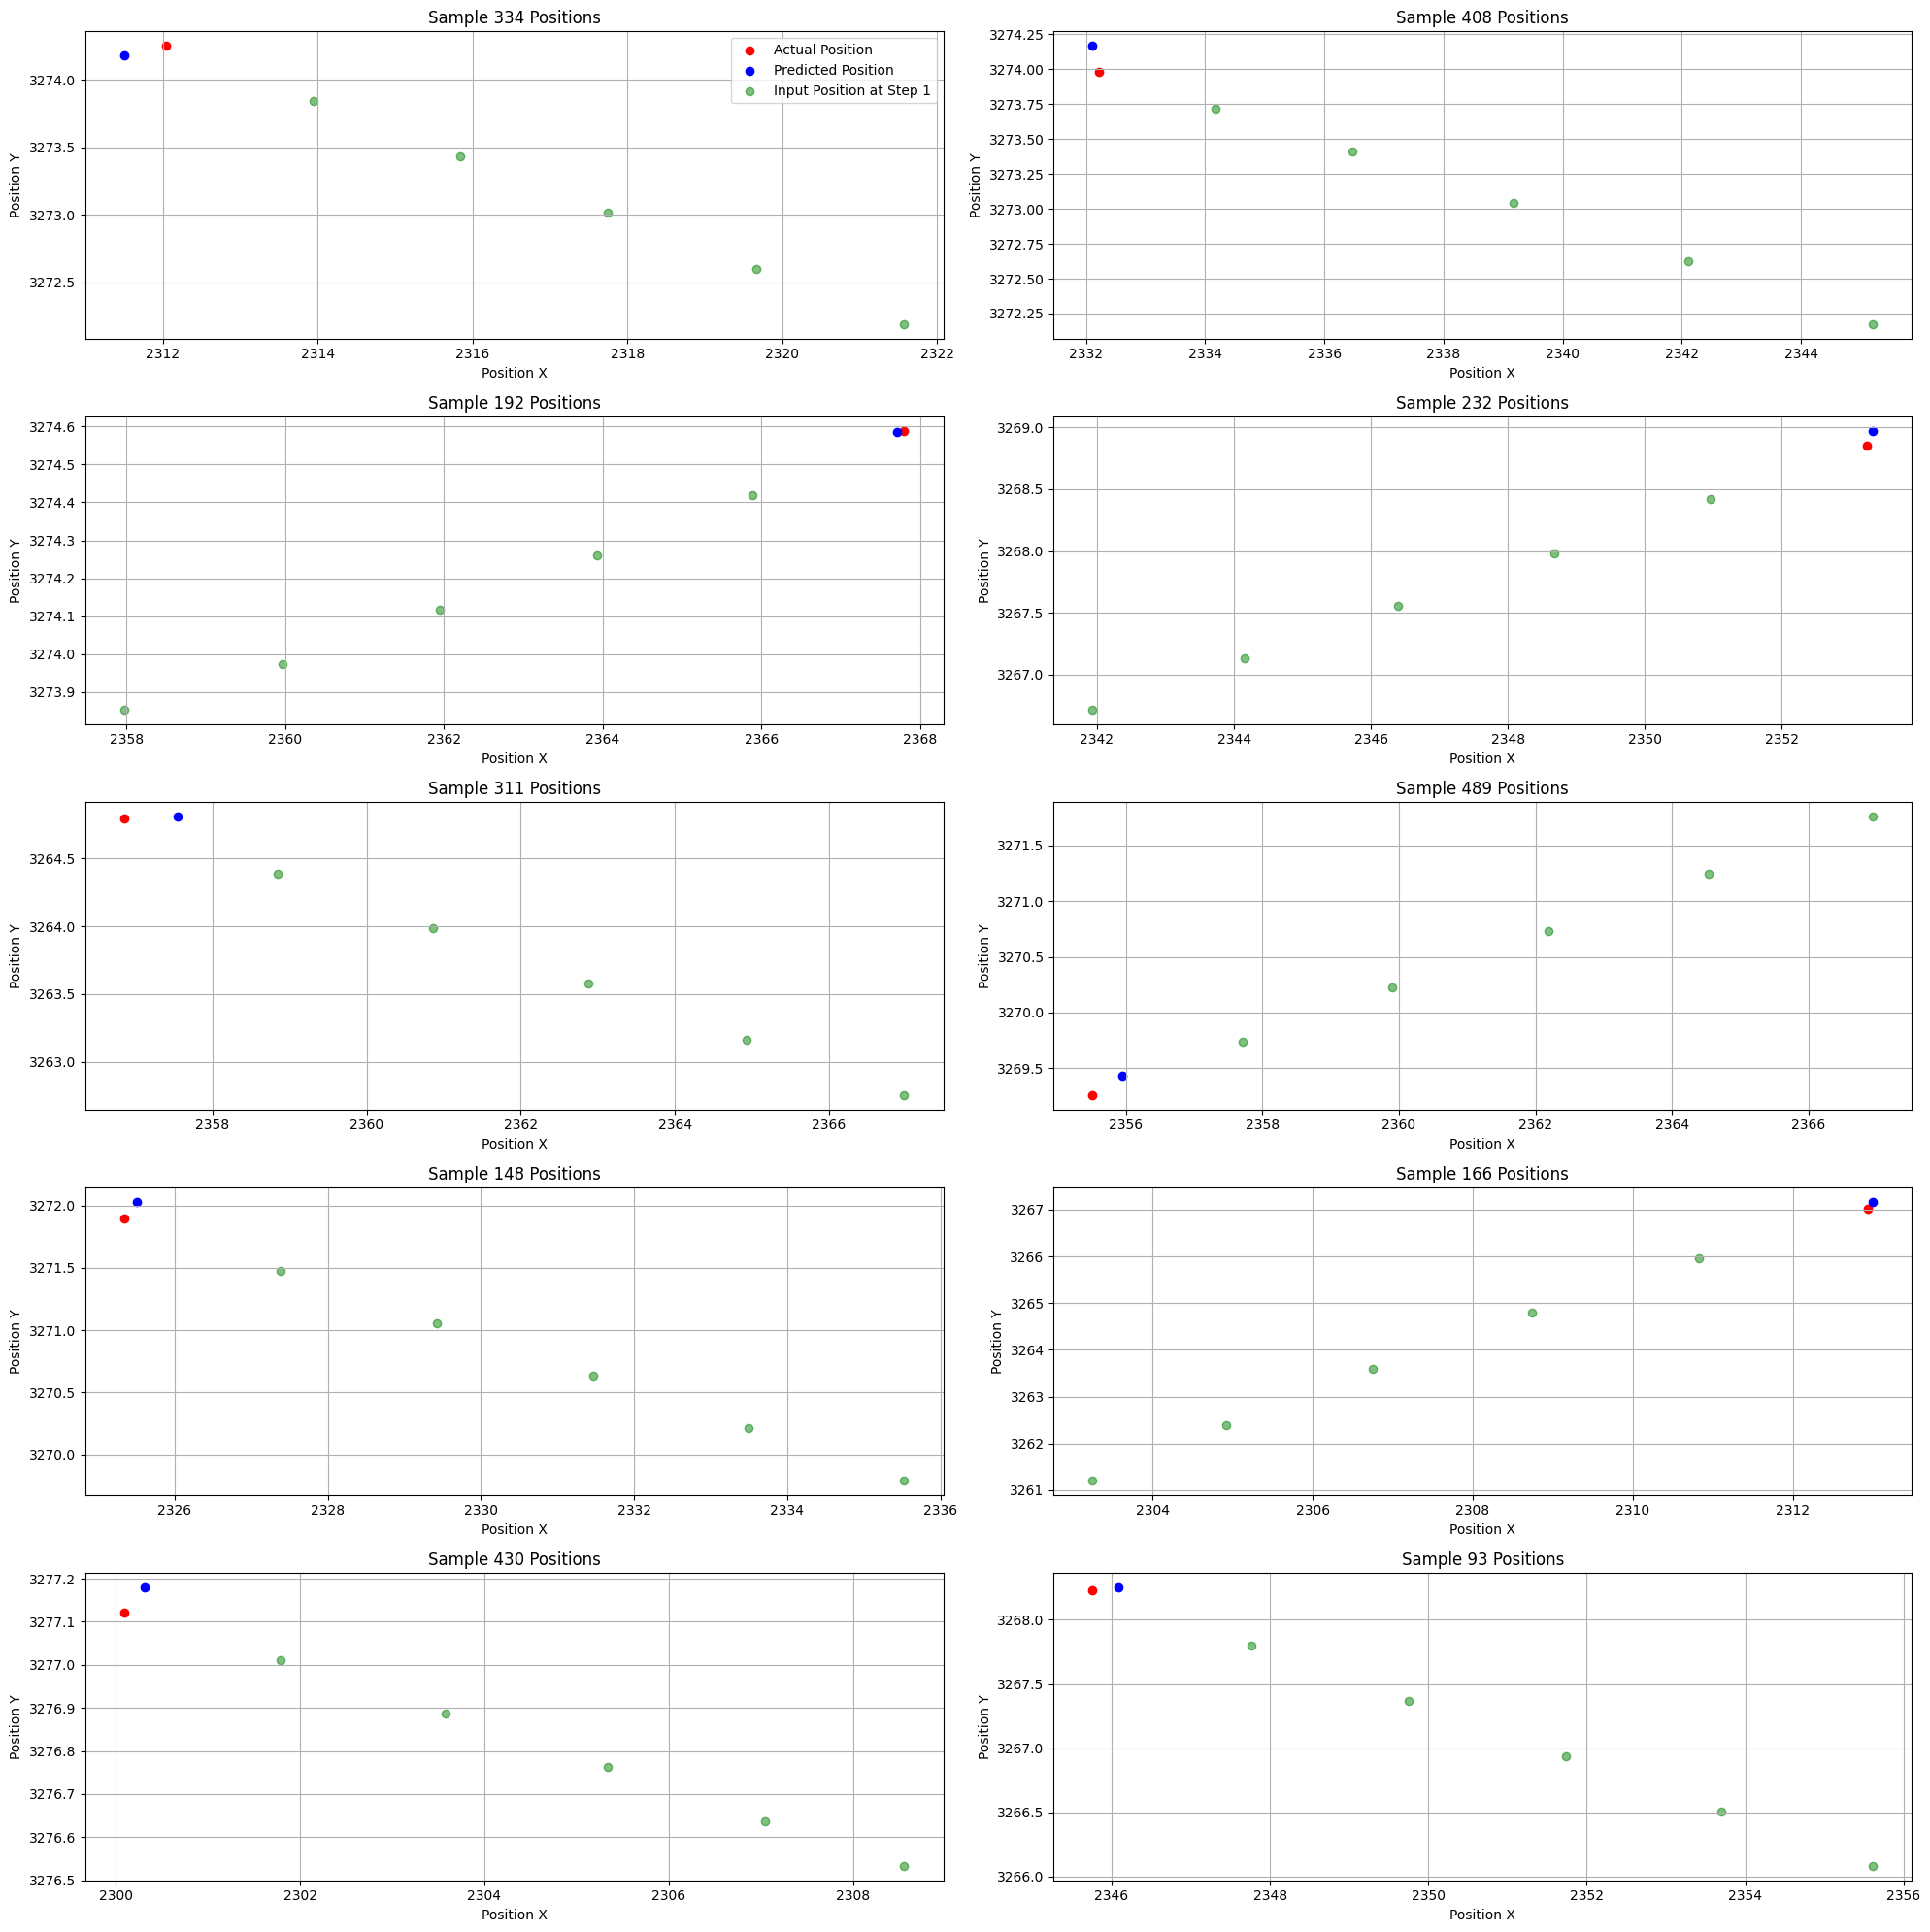

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁
val_rel_error_pt,█▂▁▁▁▁▁▁▁▁
epoch,149
train_loss,7e-05
val_loss,7e-05
val_rel_error_pt,0.00193


wandb: Agent Starting Run: ys9uwj42 with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Current Epoch: 15/150
The training loss is 0.0025550040882080793
The validation loss is 0.004850317258387804
The mean relative error (in percentage) for the validation set: 0.015903204679489136
Current Epoch: 30/150
The training loss is 0.0009175420273095369
The validation loss is 0.0005491080810315907
The mean relative error (in percentage) for the validation set: 0.005350919906049967
Current Epoch: 45/150
The training loss is 0.0002698661701288074
The validation loss is 0.00017522502457723022
The mean relative error (in percentage) for the validation set: 0.003022718010470271
Current Epoch: 60/150
The training loss is 7.026762614259496e-05
The validation loss is 0.00013214950740803033
The mean relative error (in percentage) for the validation set: 0.002625018125399947
Current Epoch: 75/150
The training loss is 7.258874393301085e-05
The validation loss is 0.0001198315731016919
The mean relative error (in percentage) for the validation set: 0.002499684225767851
Current Epoch: 90/150
Th

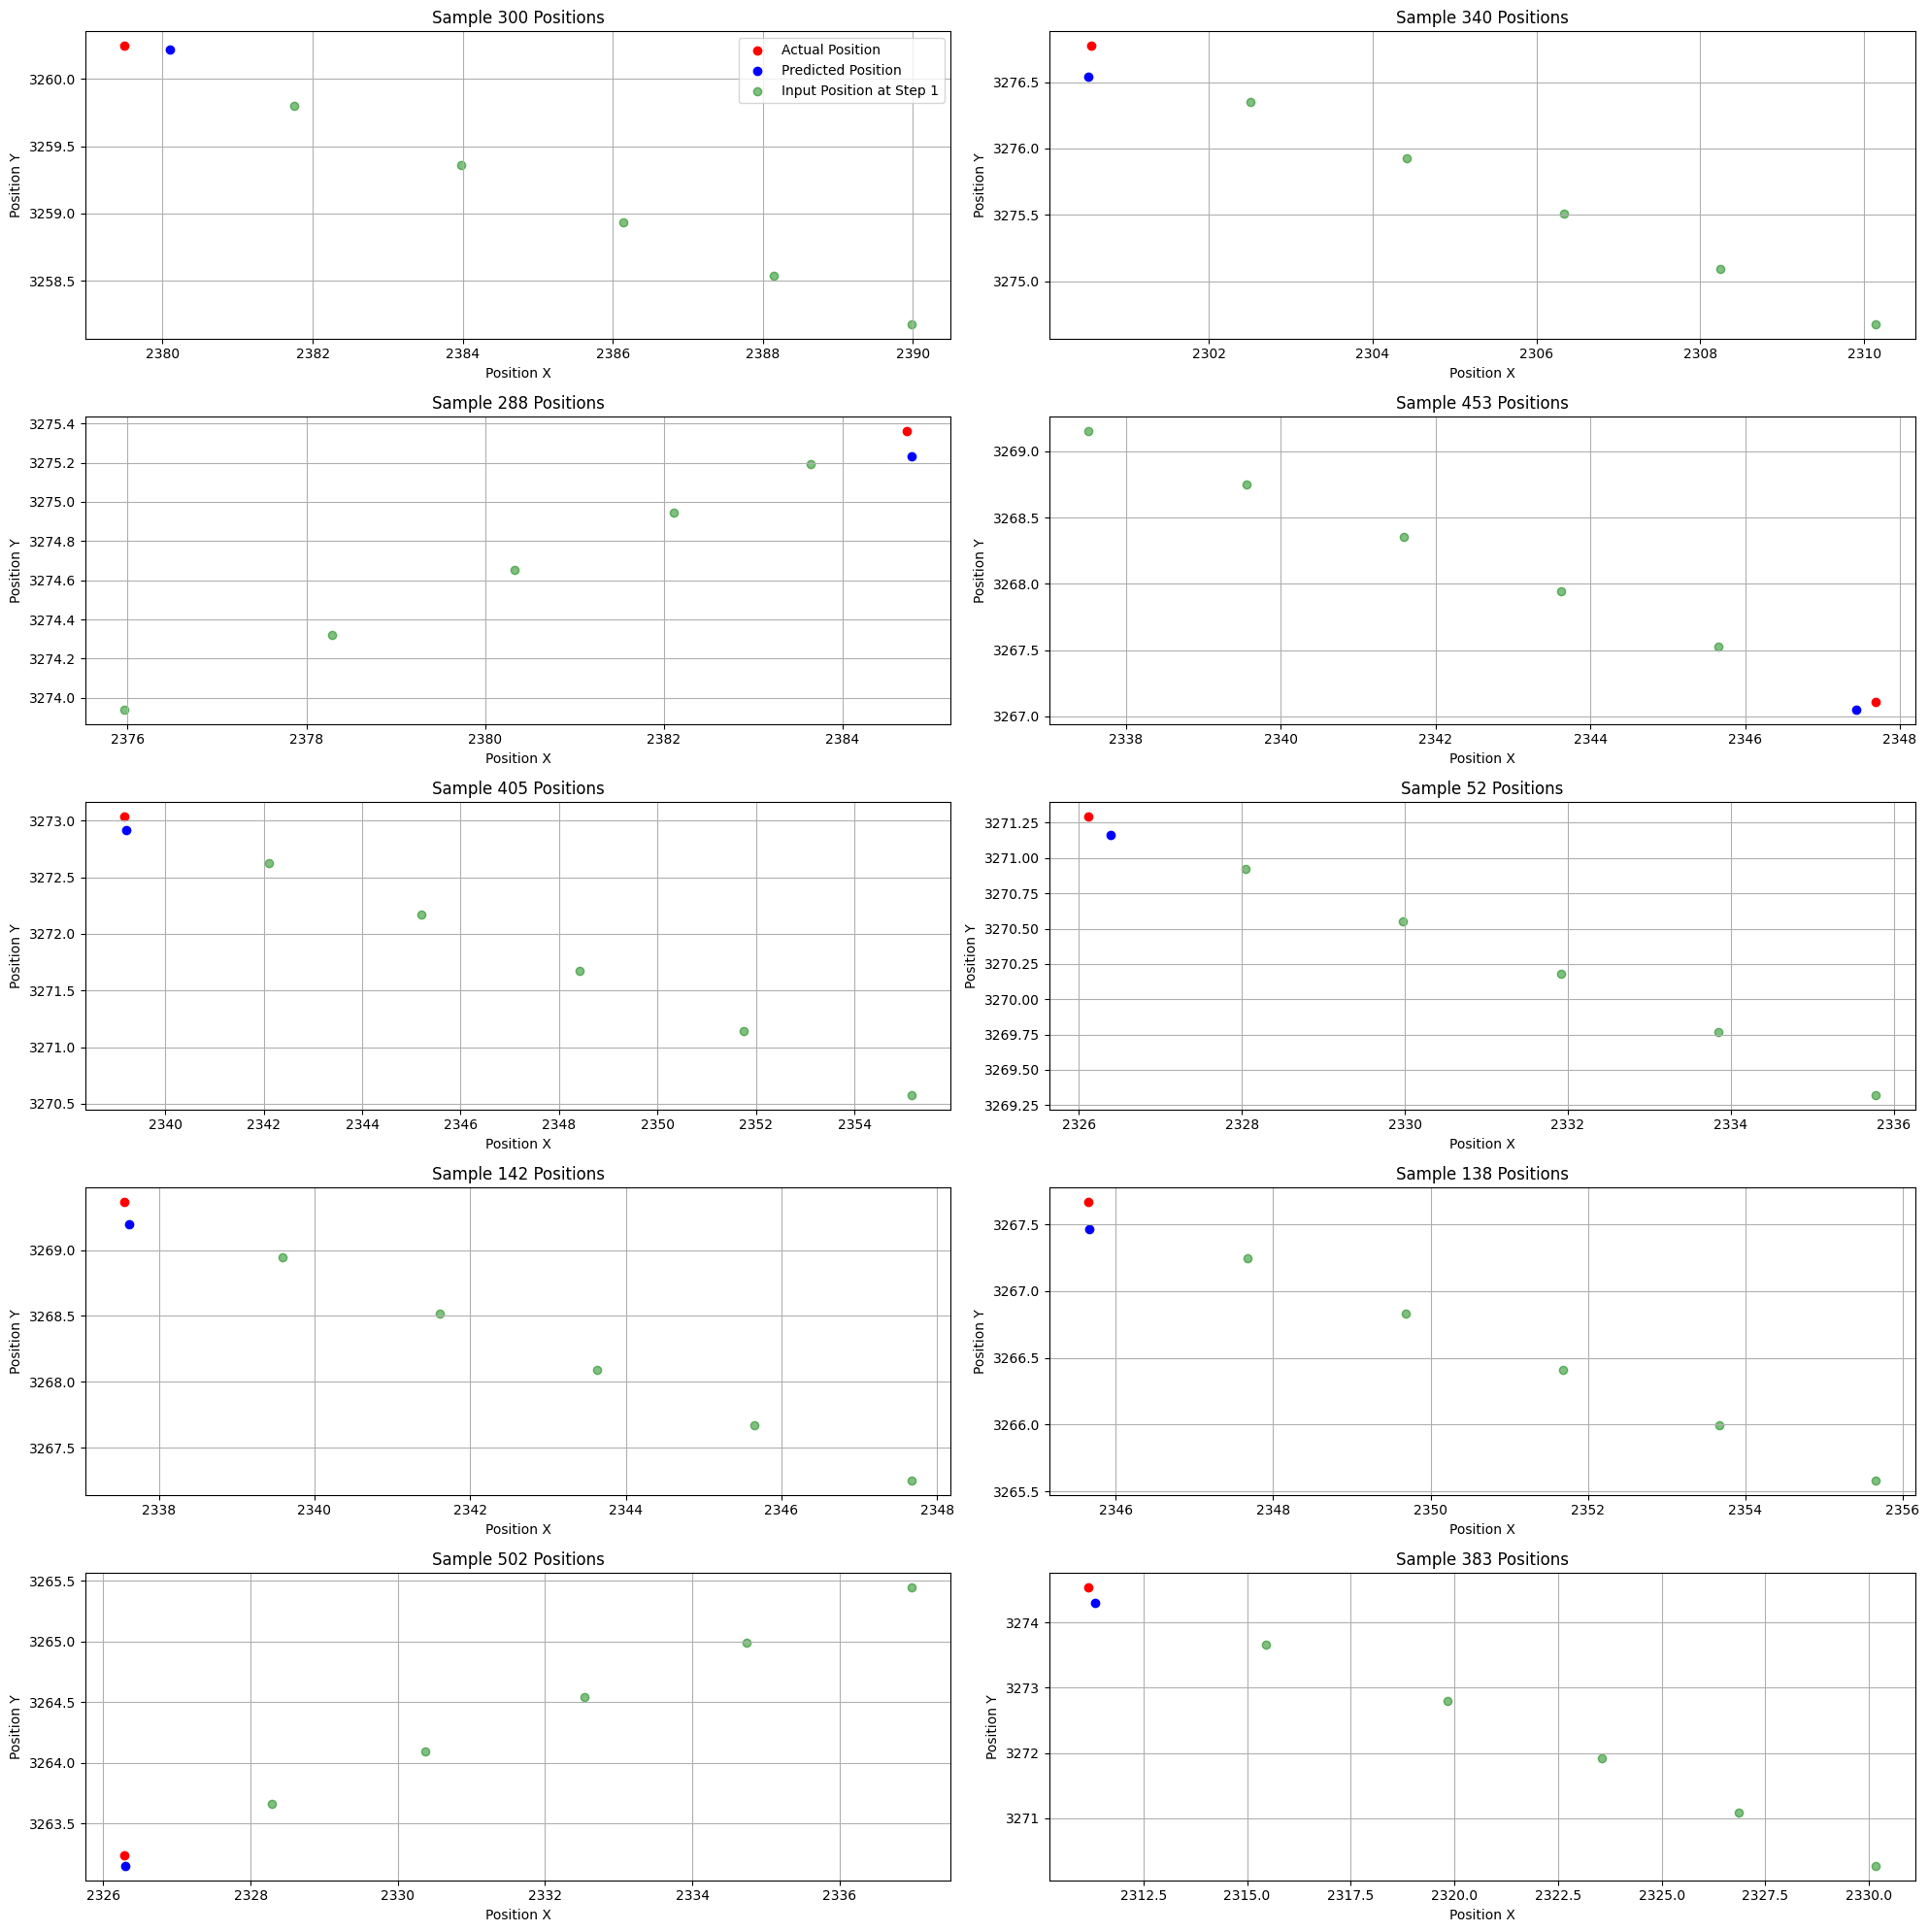

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁
val_rel_error_pt,█▃▂▁▁▁▁▁▁▁
epoch,149
train_loss,0.00013
val_loss,7e-05
val_rel_error_pt,0.0019


wandb: Agent Starting Run: 8vyzyaxf with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Current Epoch: 15/150
The training loss is 0.0009148058015853167
The validation loss is 0.0009852161165326834
The mean relative error (in percentage) for the validation set: 0.007167460396885872
Current Epoch: 30/150
The training loss is 0.00025865258066914976
The validation loss is 0.00014451955212280154
The mean relative error (in percentage) for the validation set: 0.002745129633694887
Current Epoch: 45/150
The training loss is 9.780436812434345e-05
The validation loss is 8.687340596225113e-05
The mean relative error (in percentage) for the validation set: 0.002128349617123604
Current Epoch: 60/150
The training loss is 5.7506971643306315e-05
The validation loss is 0.00010034042497863993
The mean relative error (in percentage) for the validation set: 0.0022873757407069206
Current Epoch: 75/150
The training loss is 3.9545873733004555e-05
The validation loss is 8.644105400890112e-05
The mean relative error (in percentage) for the validation set: 0.002123046899214387
Current Epoch: 90/1

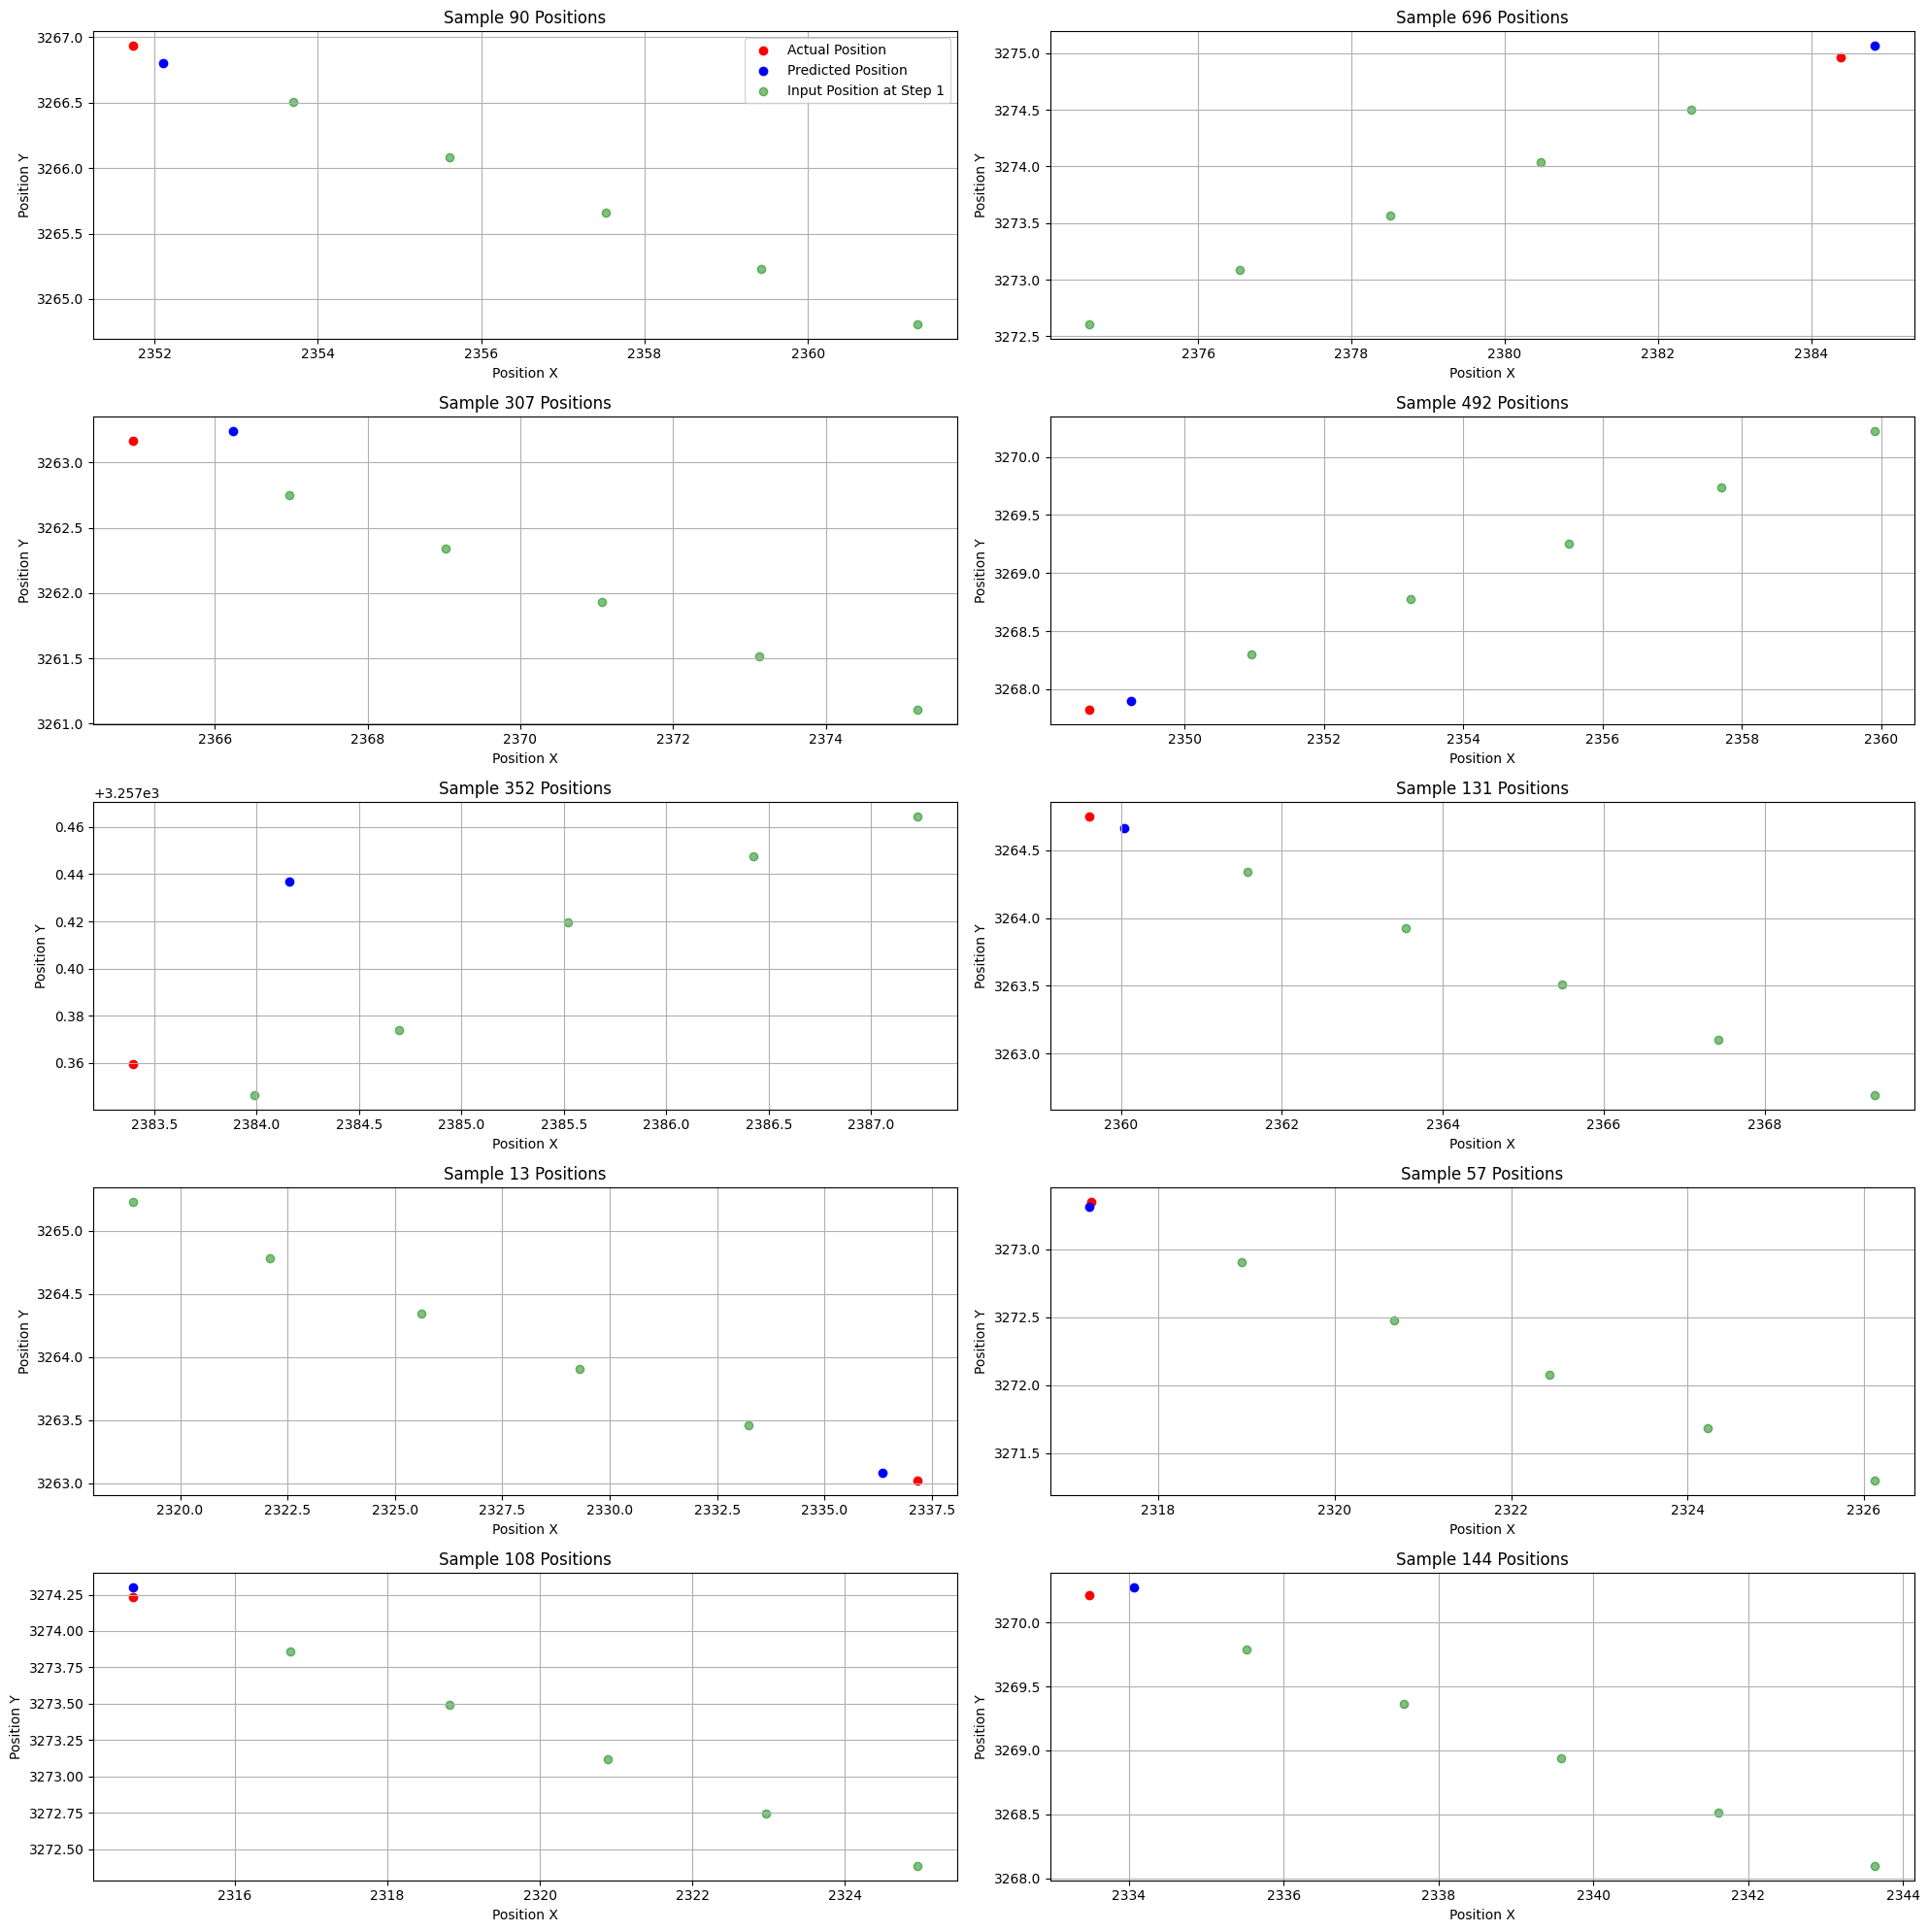

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁
val_rel_error_pt,█▂▁▁▁▁▁▁▁▁
epoch,149
train_loss,6e-05
val_loss,7e-05
val_rel_error_pt,0.00196


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jlwci1v4 with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Current Epoch: 15/150
The training loss is 0.0037105598021298647
The validation loss is 0.004585742950439453
The mean relative error (in percentage) for the validation set: 0.01546337828040123
Current Epoch: 30/150
The training loss is 0.0010222438722848892
The validation loss is 0.0004610525502357632
The mean relative error (in percentage) for the validation set: 0.004903145134449005
Current Epoch: 45/150
The training loss is 0.00020402981317602098
The validation loss is 0.00016038278408814222
The mean relative error (in percentage) for the validation set: 0.0028918678872287273
Current Epoch: 60/150
The training loss is 9.7375683253631e-05
The validation loss is 0.00011192820238647982
The mean relative error (in percentage) for the validation set: 0.002415846101939678
Current Epoch: 75/150
The training loss is 7.084876415319741e-05
The validation loss is 7.829878450138494e-05
The mean relative error (in percentage) for the validation set: 0.0020205846522003412
Current Epoch: 90/150
Th

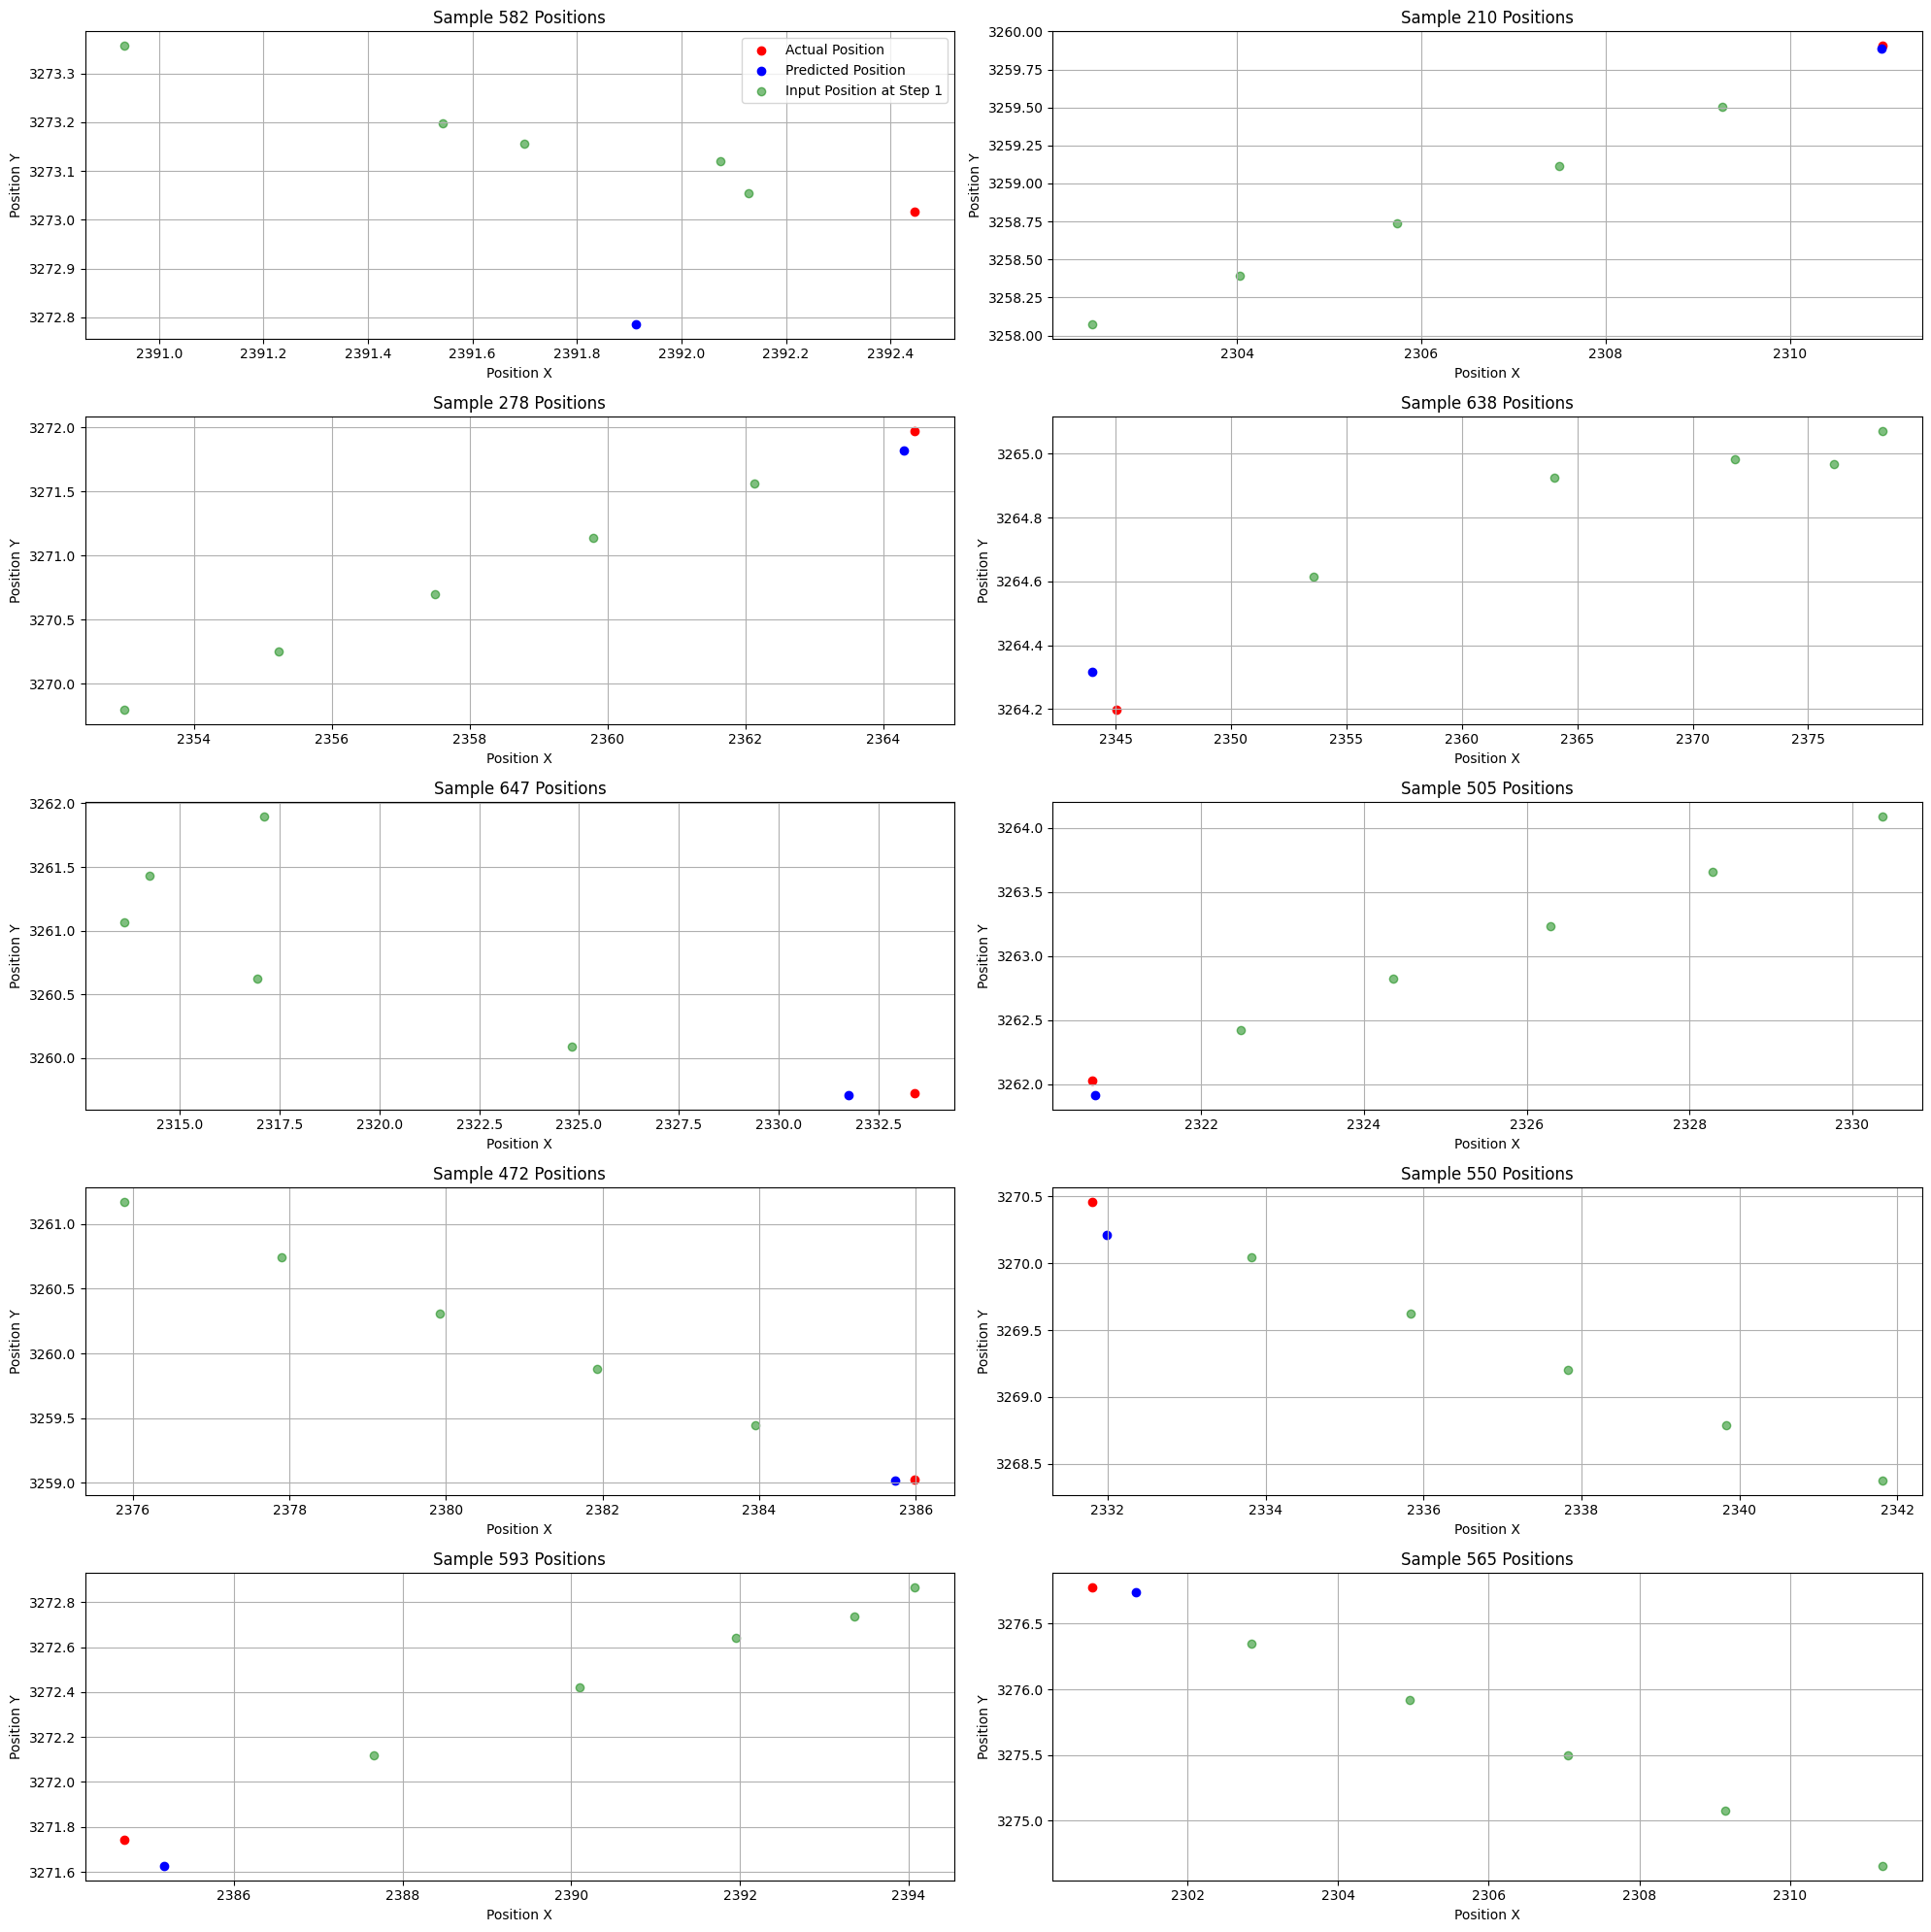

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁
val_rel_error_pt,█▃▂▁▁▁▁▁▁▁
epoch,149
train_loss,0.00013
val_loss,7e-05
val_rel_error_pt,0.00185


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x23ym73a with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Current Epoch: 15/150
The training loss is 0.0013117719208821654
The validation loss is 0.003025824436917901
The mean relative error (in percentage) for the validation set: 0.012560918927192688
Current Epoch: 30/150
The training loss is 0.00037465442437678576
The validation loss is 0.000567099719773978
The mean relative error (in percentage) for the validation set: 0.0054378751665353775
Current Epoch: 45/150
The training loss is 0.00018817218369804323
The validation loss is 0.00033277401234954596
The mean relative error (in percentage) for the validation set: 0.0041655683889985085
Current Epoch: 60/150
The training loss is 0.0001328177168034017
The validation loss is 0.0002016642247326672
The mean relative error (in percentage) for the validation set: 0.0032427539117634296
Current Epoch: 75/150
The training loss is 0.00013182673137634993
The validation loss is 0.00013640148972626776
The mean relative error (in percentage) for the validation set: 0.002666914602741599
Current Epoch: 90/1

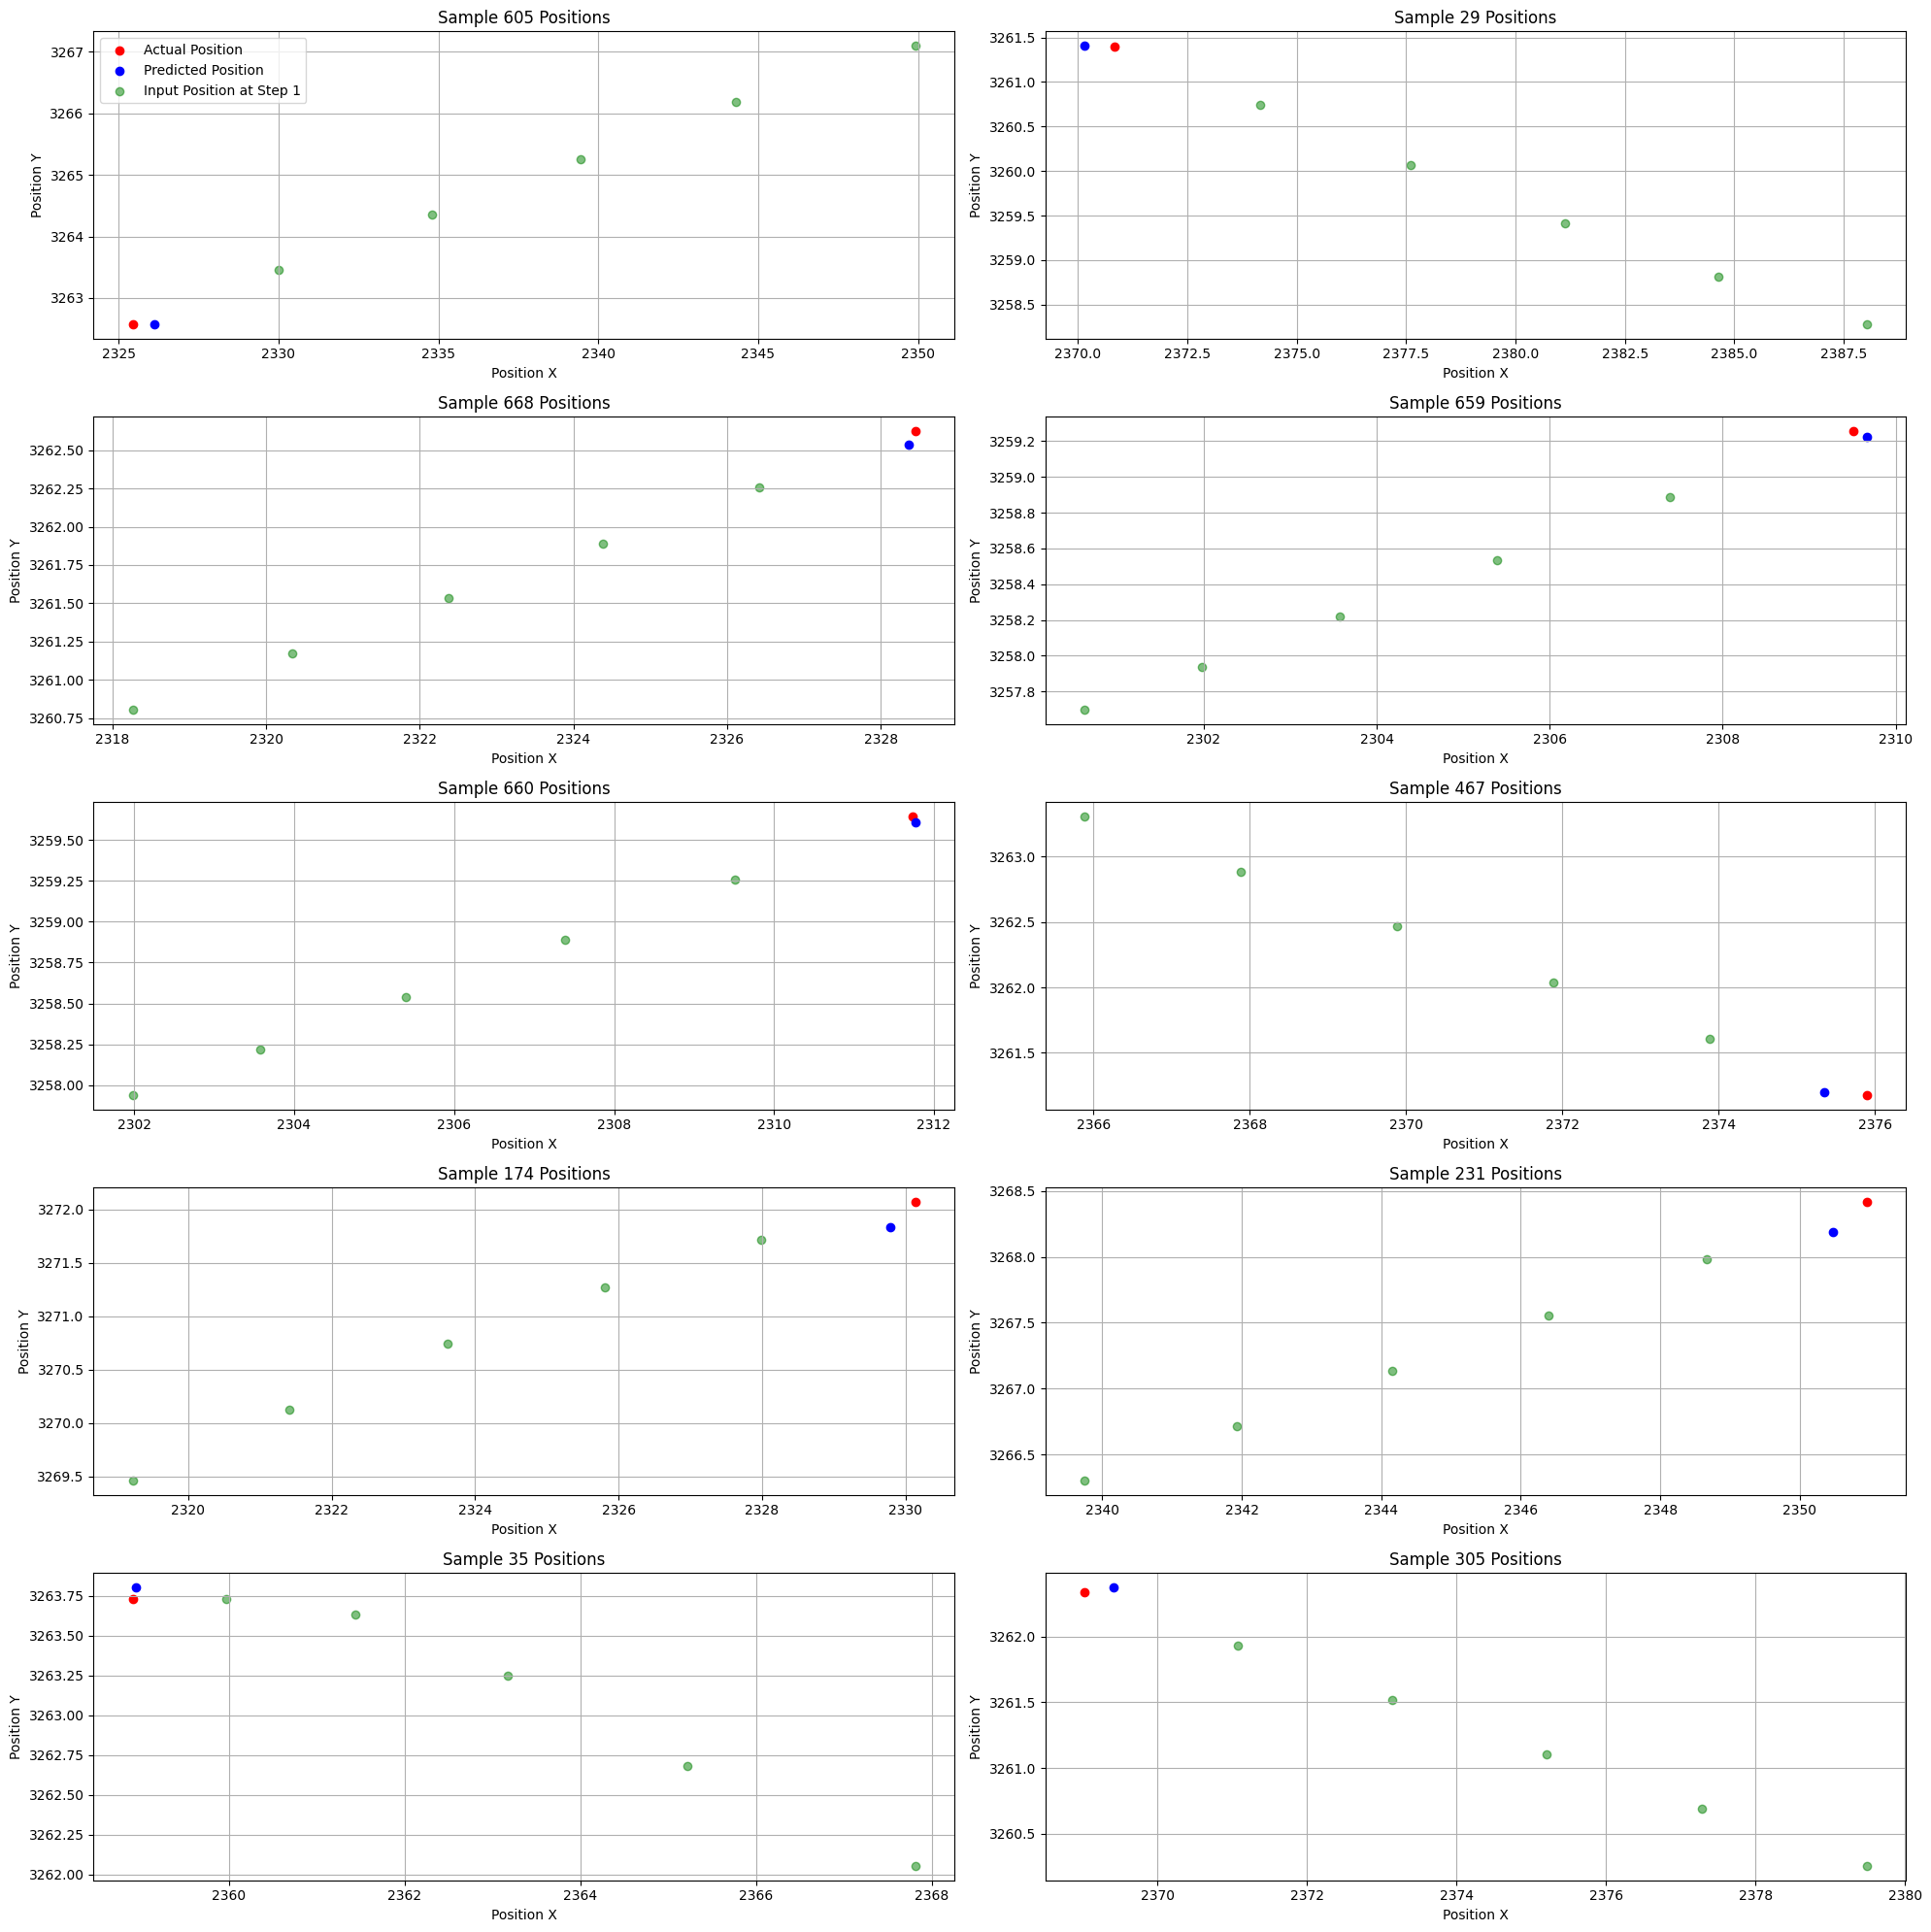

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁
val_rel_error_pt,█▃▂▂▁▁▁▁▁▁
epoch,149
train_loss,8e-05
val_loss,0.00011
val_rel_error_pt,0.00235


wandb: Agent Starting Run: 2c7793nf with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Current Epoch: 15/150
The training loss is 0.0025081071071326733
The validation loss is 0.005544864572584629
The mean relative error (in percentage) for the validation set: 0.01700376160442829
Current Epoch: 30/150
The training loss is 0.0008715858566574752
The validation loss is 0.0022509226109832525
The mean relative error (in percentage) for the validation set: 0.010833775624632835
Current Epoch: 45/150
The training loss is 0.0004895020392723382
The validation loss is 0.000691032677423209
The mean relative error (in percentage) for the validation set: 0.006002729758620262
Current Epoch: 60/150
The training loss is 0.0002981290454044938
The validation loss is 0.00040925992652773857
The mean relative error (in percentage) for the validation set: 0.00461954390630126
Current Epoch: 75/150
The training loss is 0.00016810167289804667
The validation loss is 0.0002779311907943338
The mean relative error (in percentage) for the validation set: 0.0038068711291998625
Current Epoch: 90/150
The 

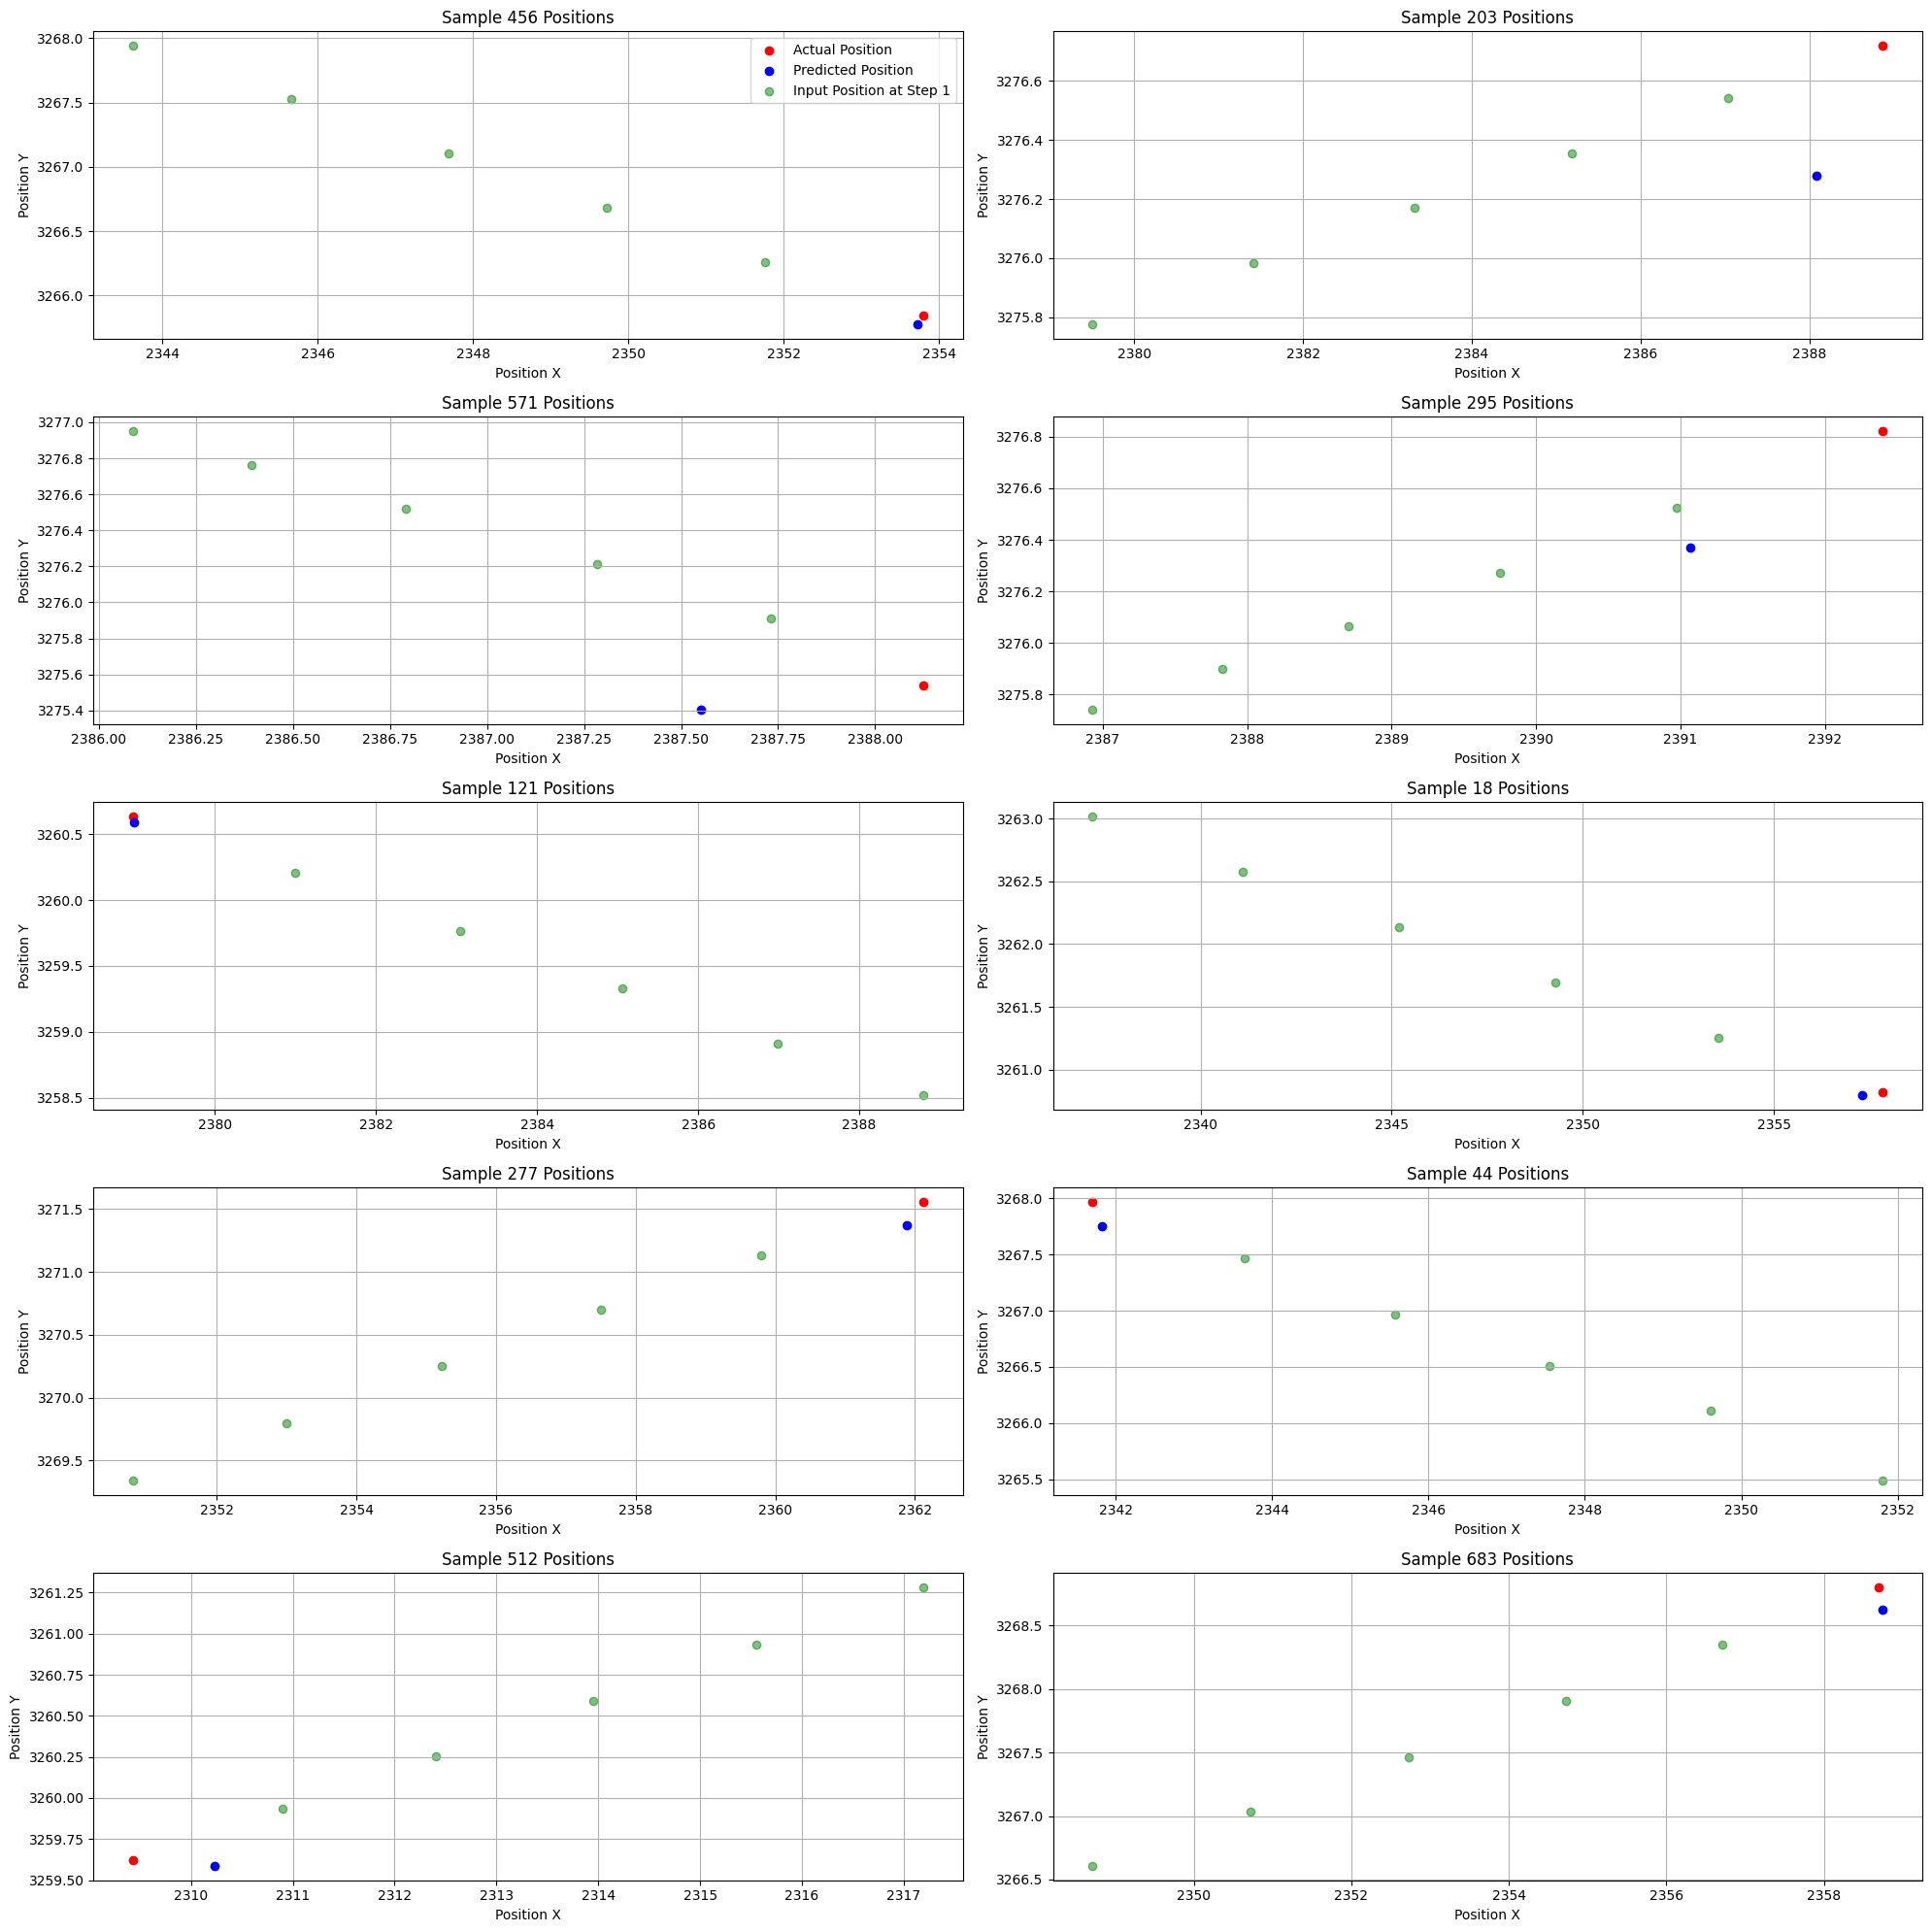

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁
val_rel_error_pt,█▅▃▂▂▂▁▁▁▁
epoch,149
train_loss,9e-05
val_loss,9e-05
val_rel_error_pt,0.00214


wandb: Agent Starting Run: 193pk3z4 with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Current Epoch: 15/150
The training loss is 0.001166482805274427
The validation loss is 0.0021155672147870064
The mean relative error (in percentage) for the validation set: 0.010502989403903484
Current Epoch: 30/150
The training loss is 0.0002184532058890909
The validation loss is 0.0004536488268058747
The mean relative error (in percentage) for the validation set: 0.004863617941737175
Current Epoch: 45/150
The training loss is 0.00010518702038098127
The validation loss is 0.0001651886268518865
The mean relative error (in percentage) for the validation set: 0.002934874966740608
Current Epoch: 60/150
The training loss is 0.00010242682037642226
The validation loss is 0.0001206565139000304
The mean relative error (in percentage) for the validation set: 0.0025082738138735294
Current Epoch: 75/150
The training loss is 0.00015709048602730036
The validation loss is 0.00010427756933495402
The mean relative error (in percentage) for the validation set: 0.002331819850951433
Current Epoch: 90/150

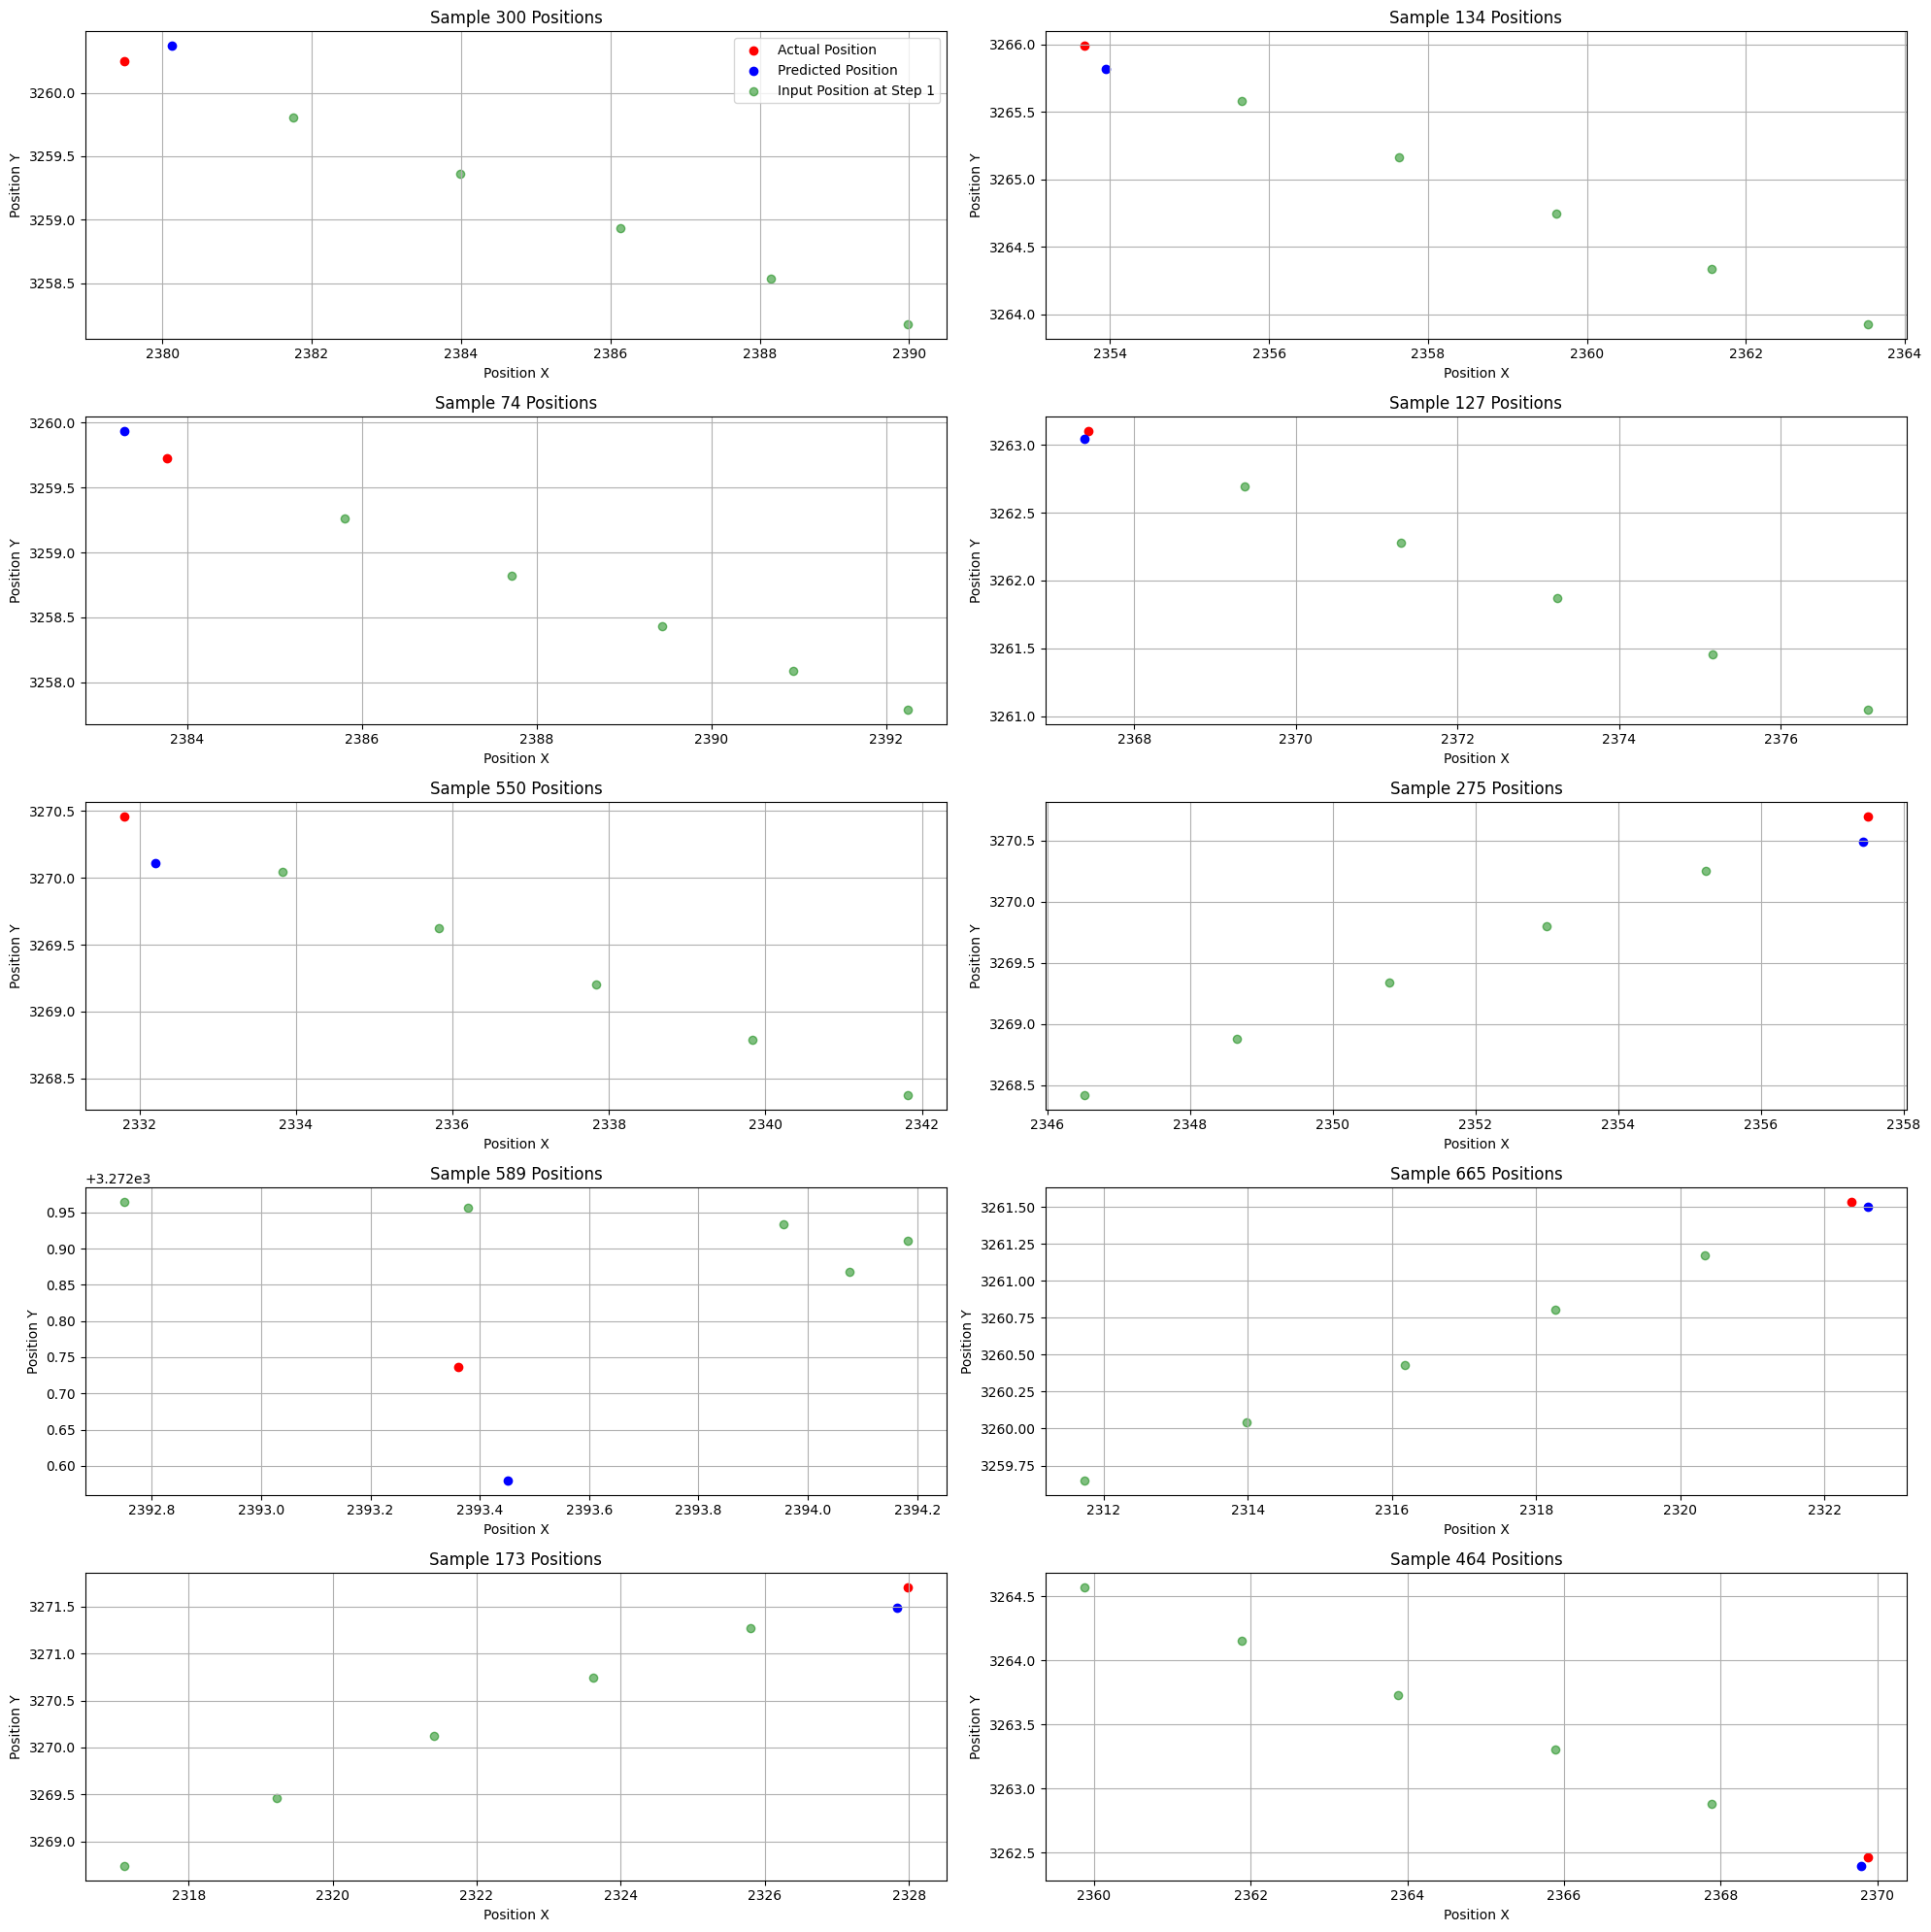

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▂▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁
val_rel_error_pt,█▃▂▁▁▁▁▁▁▁
epoch,149
train_loss,7e-05
val_loss,0.0001
val_rel_error_pt,0.00226


wandb: Agent Starting Run: yj8q15we with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Current Epoch: 15/150
The training loss is 0.0031093615107238293
The validation loss is 0.005619566421955824
The mean relative error (in percentage) for the validation set: 0.01711791753768921
Current Epoch: 30/150
The training loss is 0.0007850875845178962
The validation loss is 0.0012562599731609225
The mean relative error (in percentage) for the validation set: 0.008093554526567459
Current Epoch: 45/150
The training loss is 0.0003556630981620401
The validation loss is 0.0005996702238917351
The mean relative error (in percentage) for the validation set: 0.005591853521764278
Current Epoch: 60/150
The training loss is 0.0001920072827488184
The validation loss is 0.00042599253356456757
The mean relative error (in percentage) for the validation set: 0.004713033325970173
Current Epoch: 75/150
The training loss is 0.00015969692321959883
The validation loss is 0.00028795498656108975
The mean relative error (in percentage) for the validation set: 0.0038749119266867638
Current Epoch: 90/150
T

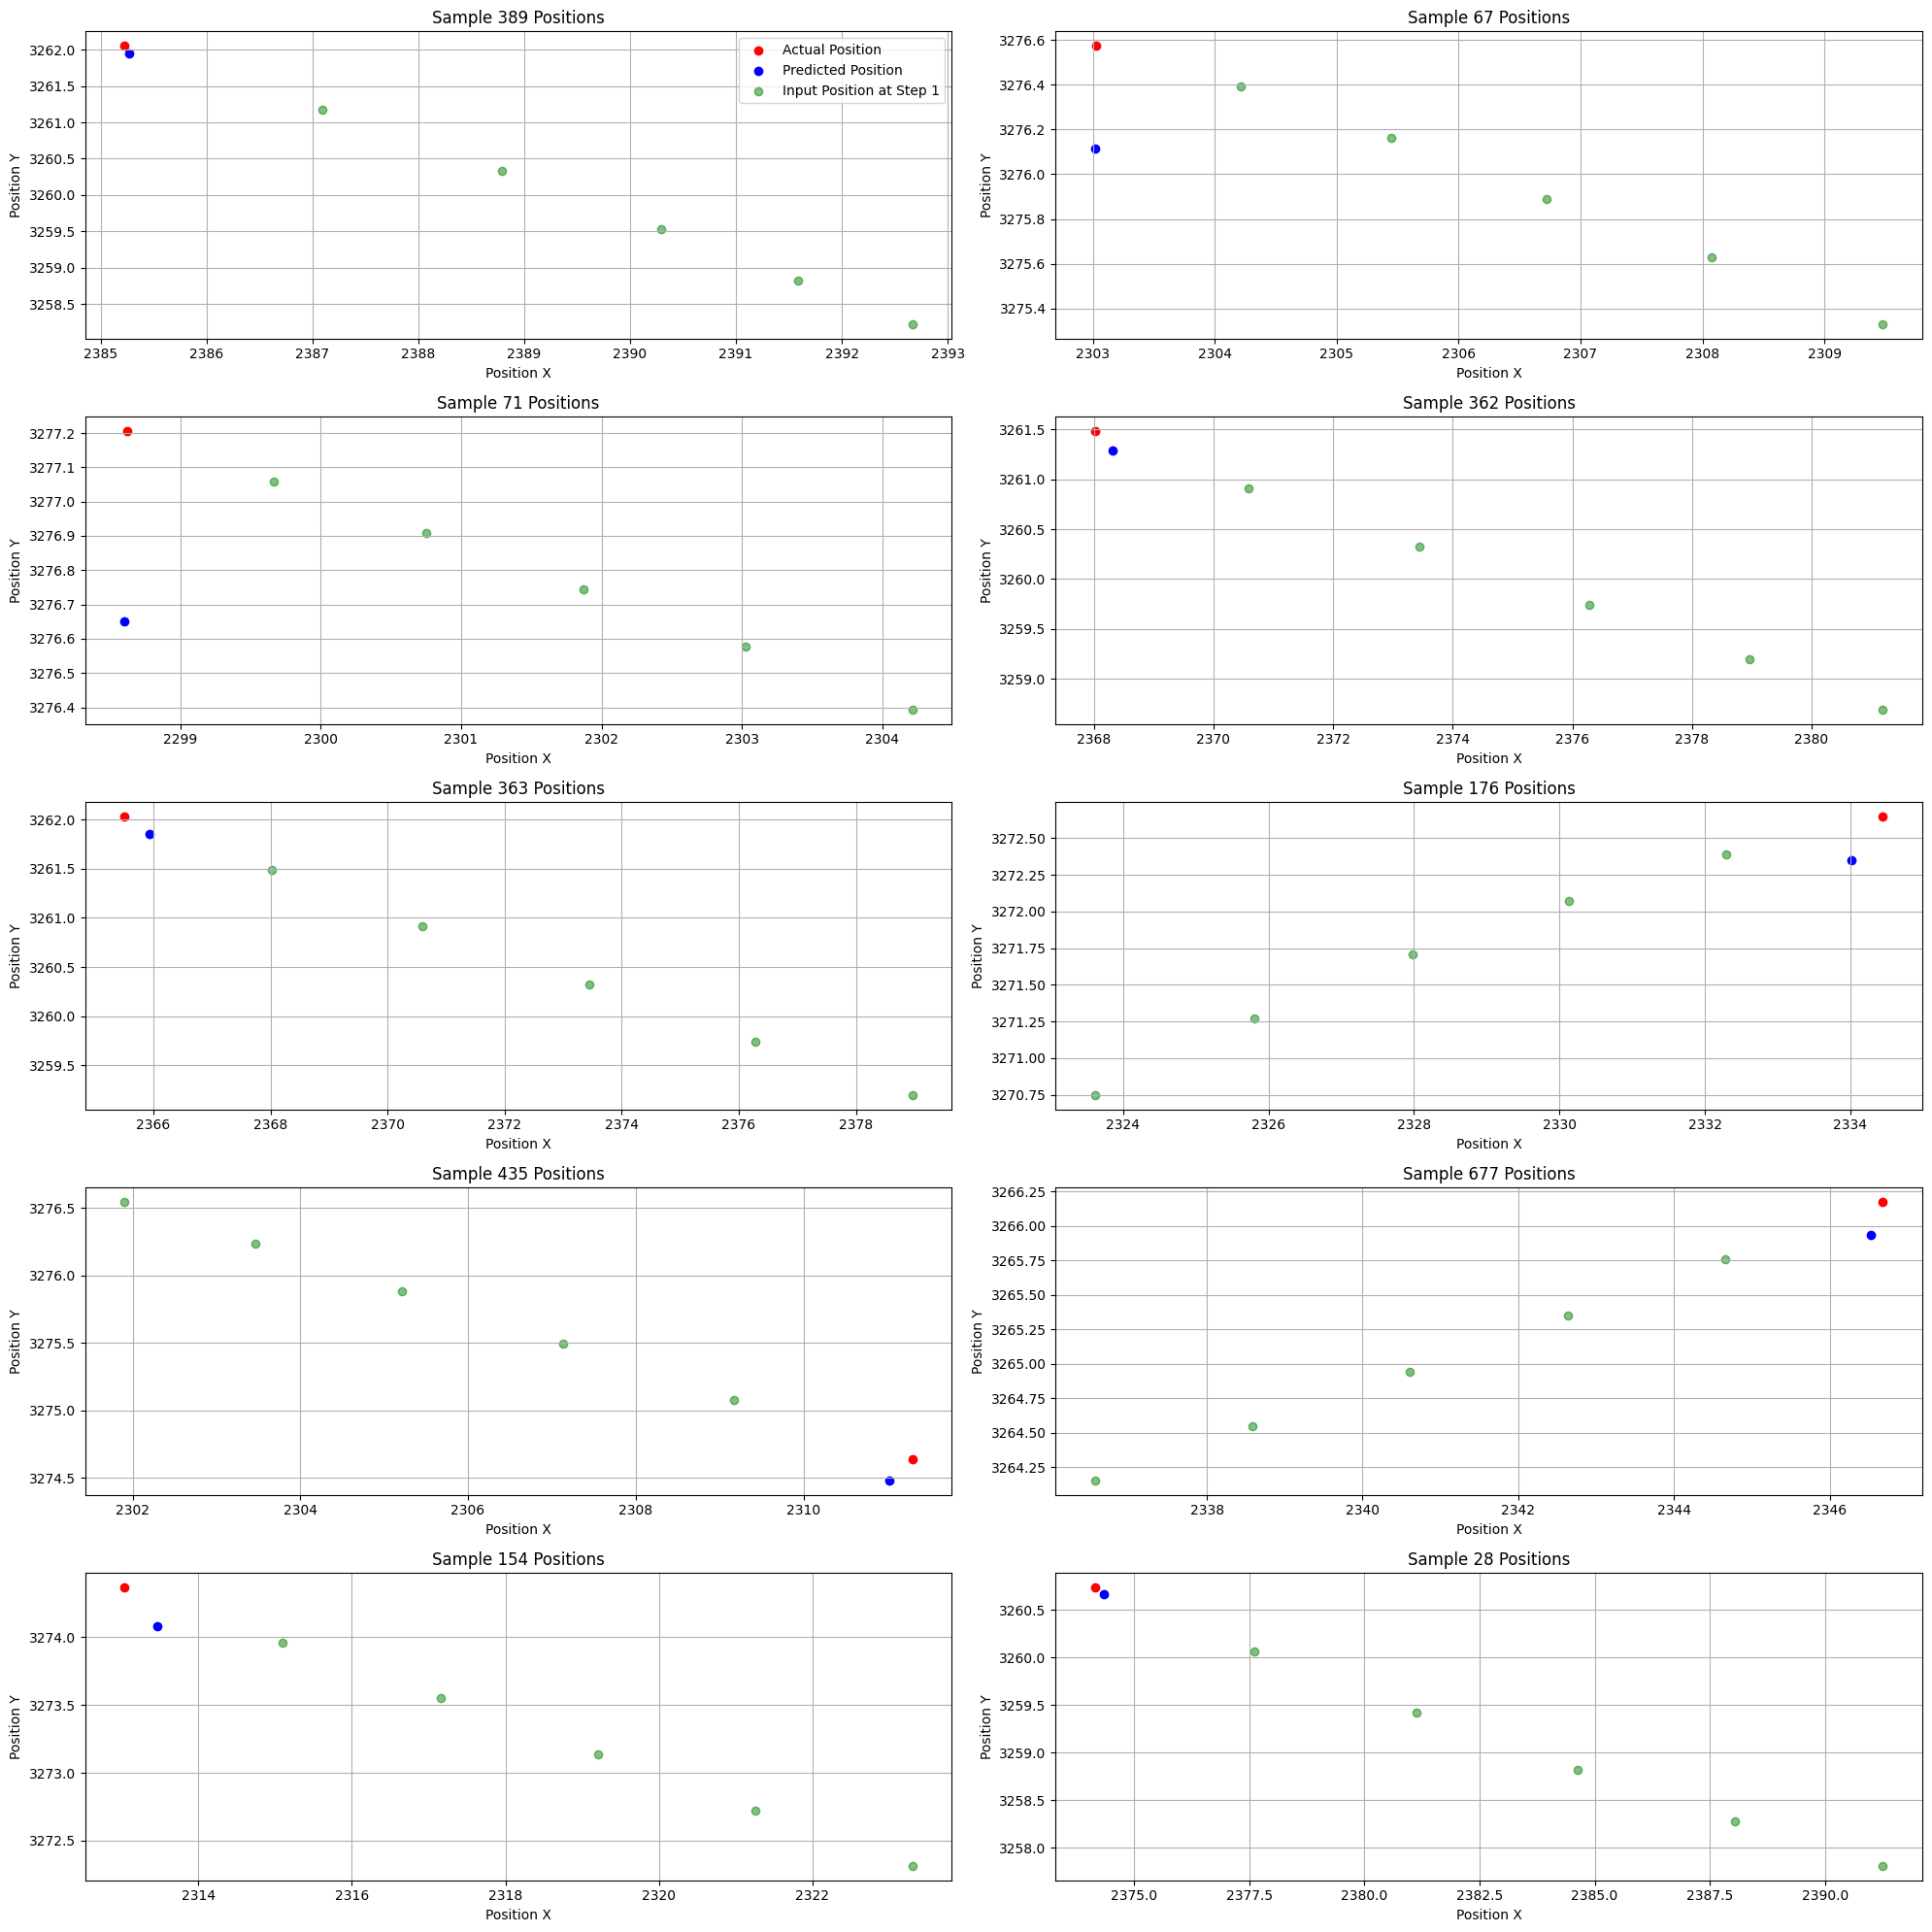

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁
val_rel_error_pt,█▄▃▂▂▁▁▁▁▁
epoch,149
train_loss,0.0001
val_loss,0.00011
val_rel_error_pt,0.00242


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Total time taken: 540.7918319702148


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import wandb
import random
random.seed(150)
torch.backends.cudnn.deterministic = True
seed_no = 108
np.random.seed(hash("improves reproducibility") % seed_no)
torch.manual_seed(hash("by removing stochasticity") % seed_no)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % seed_no)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_epochs = 150
log_freq = int(0.1 * max_epochs)


sweep_configuration = {
    "method": "grid",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": {
        "hidden_layer_size": {"values": [64, 128]},
        "learning_rate": {"values": [0.001, 0.0005]},
        "batch_size": {"values": [32, 64]}
    }
}
project_name = "ME343_FinalProject_TrajectoryPredictions_ZhiyuanLi"
group_name = "grid_search"
sweep_id = wandb.sweep(sweep_configuration, project=project_name)
import time
t1 = time.time()
# ==============================================================================
# Training
# ==============================================================================

def rel_l2_error(pred, true):
    """A helper function to compute the relative L2 error in percentage

    Args:
        pred (torch.Tensor): Predicted values
        true (torch.Tensor): True values

    Returns:
        torch.Tensor: Relative L2 error in percentage
    """
    return (torch.norm(pred - true) / torch.norm(true))*100

def train(config=None):
    wandb.init(config=config, project=project_name, group=group_name)
    config = wandb.config

    model = SimpleLSTM(input_size=5, hidden_layer_size=config.hidden_layer_size, output_size=2).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    training_loss_list = []
    validation_loss_list =[]

    for epoch in range(max_epochs):
        model.train()
        total_train_loss = 0
        for train_x, train_y in train_loader:
            train_x, train_y = train_x.to(device), train_y.to(device)
            model.zero_grad()
            output = model(train_x)
            loss = criterion(output, train_y)
            loss.backward()
            optimizer.step()

        if (epoch + 1)%15 == 0:
            training_loss_list.append(loss.item())
            model.eval()
            with torch.no_grad():
                val_pred_field = model(X_val_tensor)
                val_loss = criterion(val_pred_field, Y_val_tensor)
                MRE = rel_l2_error(val_pred_field, Y_val_tensor)/len(Y_val_tensor)
                validation_loss_list.append(val_loss.item())

                wandb.log({"val_loss": val_loss.item(), "train_loss": loss.item(), "val_rel_error_pt": MRE, "epoch": epoch})
                print(f"Current Epoch: {epoch+1}/{max_epochs}")
                print(f"The training loss is {loss.item()}")
                print(f"The validation loss is {val_loss.item()}")
                print(f"The mean relative error (in percentage) for the validation set: {MRE}")

    model.eval()
    n_plots = 10
    random_indices = random.sample(range(len(test_dataset)), n_plots)
    with torch.no_grad():
        test_field = model(X_test_tensor)
        predict_outputs = labels_scaler.inverse_transform(test_field.cpu().numpy())
        test_outputs = labels_scaler.inverse_transform(Y_test_tensor.cpu().numpy())
        num_samples, num_timesteps, num_features = X_test_tensor.shape
        X_test_reshaped = X_test_tensor.reshape(-1, num_features).cpu().numpy()

        test_inputs_transformed = scaler.inverse_transform(X_test_reshaped)
        test_inputs = test_inputs_transformed.reshape(num_samples, num_timesteps, num_features)

        fig, axs = plt.subplots(int(n_plots/2), 2, figsize=(n_plots*2, 4 * int(n_plots/2)))

        for i, index in enumerate(random_indices):
            actual_x, actual_y = test_outputs[index]
            predicted_x, predicted_y = predict_outputs[index]
            input_positions = test_inputs[index, :, :2]

            ax = axs[i // 2, i % 2]
            ax.scatter(actual_x, actual_y, c='red', label='Actual Position')
            ax.scatter(predicted_x, predicted_y, c='blue', label='Predicted Position')

            for step in range(5):
                ax.scatter(input_positions[step, 0], input_positions[step, 1], c='green', alpha=0.5, label=f'Input Position at Step {step+1}' if step == 0 else "")

            ax.set_title(f'Sample {index} Positions')
            ax.set_xlabel('Position X')
            ax.set_ylabel('Position Y')
            if i == 0:
                ax.legend()
            ax.grid(True)

        plt.tight_layout()
        wandb.log({"Prediction vs Actual Position": wandb.Image(fig)})
        plt.show()

    save_path = os.path.join(wandb.run.dir, "model.ckpt")
    torch.save(model.state_dict(), save_path)

wandb.agent(sweep_id, train)
t2 = time.time()
print(f"Total time taken: {t2-t1}")
wandb.finish()

In [ ]:
# !pip install nbconvert
# !apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!jupyter nbconvert --to pdf /content/drive/MyDrive/Colab\ Notebooks/Final_Project.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Final_Project.ipynb to pdf
[NbConvertApp] Support files will be in Final_Project_files/
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Writing 92414 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1425054 bytes to /content/drive/MyD